<a href="https://colab.research.google.com/github/gustavo159753/Analise-de-dados/blob/main/mcda_ANALISYS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install pyrepo-mcda
from pyrepo_mcda.mcda_methods import (
    TOPSIS, VIKOR, SPOTIS, WASPAS, MABAC,
    EDAS, CODAS, MULTIMOORA, COPRAS
)
from pyrepo_mcda.additions import rank_preferences

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.3 MB/s eta 0:00:00


In [3]:
# 1. Definição dos Tickers Estratégicos
tickers = [
    'LMT', 'RTX', 'NOC', 'GD',    # Bélica/Defesa
    'BA', 'AVAV',                 # Espacial/Drones
    'MP', 'LYSCF',                # Terras Raras
    'PLTR', 'XOM'                 # Inteligência/Energia
]

print(f"Buscando dados em tempo real para: {tickers}...")

Buscando dados em tempo real para: ['LMT', 'RTX', 'NOC', 'GD', 'BA', 'AVAV', 'MP', 'LYSCF', 'PLTR', 'XOM']...


In [4]:
df_prices = yf.download(tickers, period='10y')['Close'].dropna()

# 2. Cálculo dos Critérios (Construção da Matriz)
returns = df_prices.pct_change().dropna()
c1_ret = (df_prices.iloc[-1] / df_prices.iloc[0]) - 1          # Retorno Acumulado
c2_vol = returns.std() * np.sqrt(252)                         # Volatilidade Anualizada
c3_sha = c1_ret / c2_vol                                      # Índice Sharpe
c4_mdd = (df_prices / df_prices.cummax() - 1).min()            # Max Drawdown

/tmp/ipython-input-615/4125958754.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_prices = yf.download(tickers, period='10y')['Close'].dropna()
[*********************100%***********************]  10 of 10 completed


In [5]:
# Criando um DataFrame para a Matriz de Decisão
decision_matrix_df = pd.DataFrame({
    'Retorno_Acum': c1_ret,
    'Volatilidade': c2_vol,
    'Sharpe_Ratio': c3_sha,
    'Max_Drawdown': c4_mdd
}, index=df_prices.columns)

In [6]:
# --- PRINT DA MATRIZ CRIADA ---
print("\n" + "="*70)
print("MATRIZ DE DECISÃO (VALORES REAIS DE MERCADO)")
print("="*70)
print(decision_matrix_df.round(4))
print("="*70 + "\n")

# Convertendo para NumPy para o processamento
matrix = decision_matrix_df.values
weights = np.array([0.35, 0.15, 0.35, 0.15])
# 1 para Maximização, -1 para Minimização
types = np.array([1, -1, 1, 1])


MATRIZ DE DECISÃO (VALORES REAIS DE MERCADO)
        Retorno_Acum  Volatilidade  Sharpe_Ratio  Max_Drawdown
Ticker                                                        
AVAV          3.0660        0.5470        5.6055       -0.6101
BA            0.3640        0.3750        0.9705       -0.5696
GD            1.8908        0.2032        9.3046       -0.2255
LMT           0.9628        0.2231        4.3159       -0.3179
LYSCF         6.7857        0.5256       12.9112       -0.5789
MP            3.2297        0.7305        4.4214       -0.8199
NOC           1.5066        0.2457        6.1314       -0.2228
PLTR         13.1663        0.7047       18.6826       -0.8462
RTX           2.9385        0.2489       11.8067       -0.3284
XOM           4.5639        0.2848       16.0241       -0.2051



In [7]:
# 3. Configuração de Métodos
methods_config = {
    "TOPSIS": (TOPSIS(), True),
    "VIKOR": (VIKOR(), False),
    "SPOTIS": (SPOTIS(), False),
    "WASPAS": (WASPAS(), True),
    "MABAC": (MABAC(), True),
    "EDAS": (EDAS(), True),
    "CODAS": (CODAS(), True),
    "MULTIMOORA": (MULTIMOORA(), True),
    "COPRAS": (COPRAS(), True)
}

df_ranks = pd.DataFrame(index=decision_matrix_df.index)

Erro no método SPOTIS: boolean index did not match indexed array along axis 1; size of axis is 2 but size of corresponding boolean axis is 4
Erro no método MABAC: module 'numpy' has no attribute 'product'


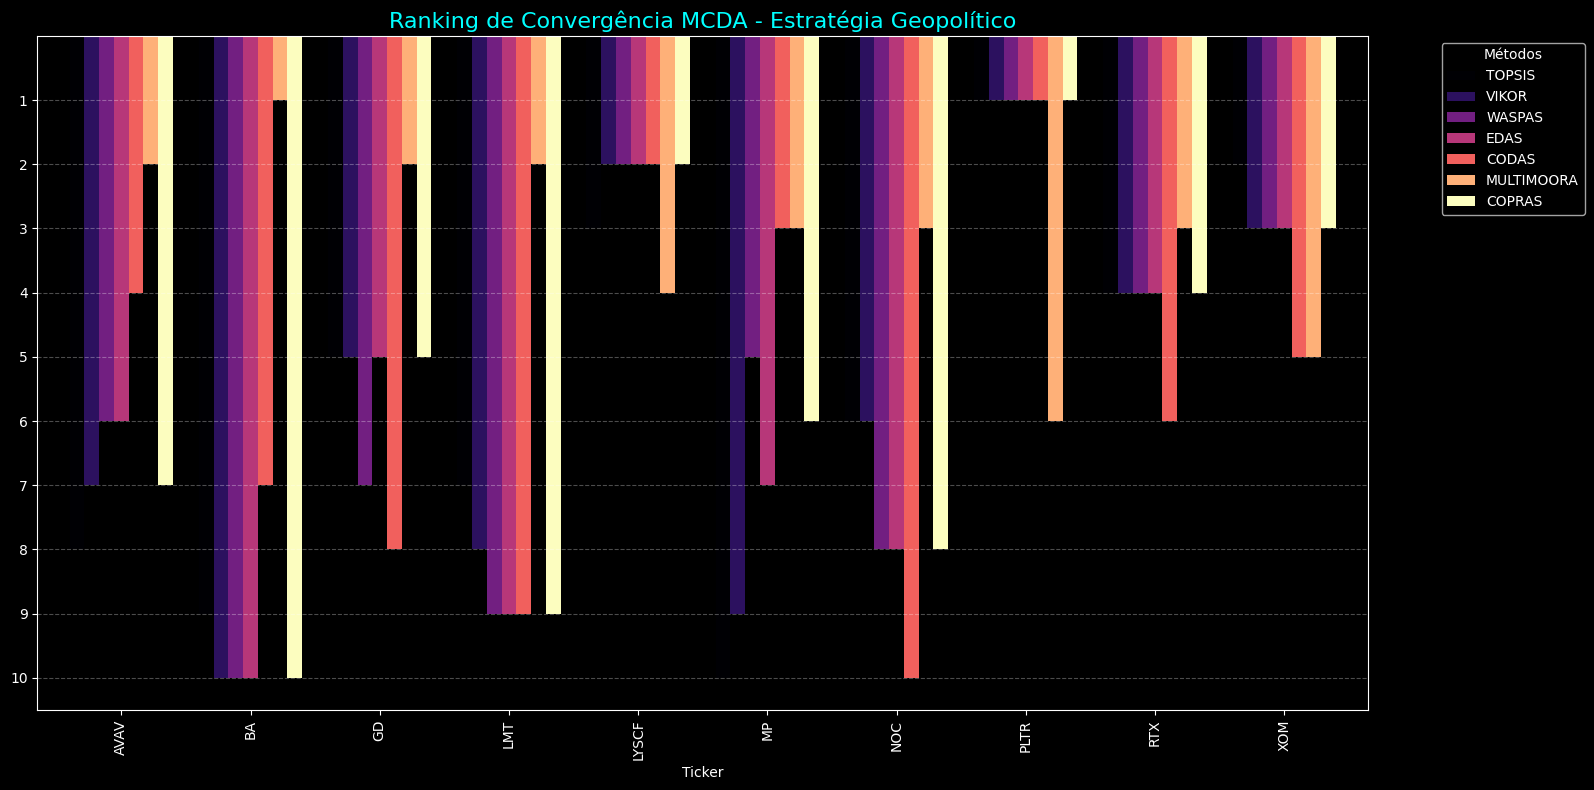


--- RANKING FINAL (CONSENSO GEOPOLÍTICO) ---
Ticker
PLTR      1
LYSCF     2
XOM       3
RTX       4
GD        5
AVAV      6
MP        7
NOC       8
LMT       9
BA       10
Name: FINAL_RANK, dtype: int64


In [8]:
# 4. Execução dos Métodos com Correção para o SPOTIS
for name, (method, is_reverse) in methods_config.items():
    try:
        if name == "SPOTIS":
            bounds = np.vstack([
                matrix.min(axis=0),
                matrix.max(axis=0)
            ]).T
            pref = method(matrix, weights, types, bounds)
        else:
            pref = method(matrix, weights, types)

        df_ranks[name] = rank_preferences(pref, reverse=is_reverse)
    except Exception as e:
        print(f"Erro no método {name}: {e}")

# 5. Visualização e Gráfico
plt.style.use('dark_background')
ax = df_ranks.plot(kind='bar', figsize=(16, 8), width=0.8, colormap='magma')
plt.title('Ranking de Convergência MCDA - Estratégia Geopolítico', fontsize=16, color='cyan')
plt.gca().invert_yaxis()
plt.yticks(range(1, len(tickers) + 1))
plt.legend(title='Métodos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Resultado Consolidado
df_ranks['MEDIA_RANK'] = df_ranks.mean(axis=1)
df_ranks['FINAL_RANK'] = df_ranks['MEDIA_RANK'].rank().astype(int)
print("\n--- RANKING FINAL (CONSENSO GEOPOLÍTICO) ---")
print(df_ranks['FINAL_RANK'].sort_values())

In [9]:
import pyrepo_mcda
print(dir(pyrepo_mcda))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'additions', 'compromise_rankings', 'correlations', 'distance_metrics', 'mcda_methods', 'normalizations', 'sensitivity_analysis_weights_percentages', 'sensitivity_analysis_weights_values', 'weighting_methods']



Análise de Sensibilidade: Retorno (C1)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       8 |      7 |     7 |
| $A_{2}$           |     9 |     9 |     9 |    9 |    9 |     10 |   10 |      10 |     10 |    10 |
| $A_{3}$           |     5 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       7 |      8 |     9 |
| $A_{5}$           |     4 |     4 |     3 |    3 |    3 |      3 |    3 |       2 |      2 |     2 |
| $A_{6}$           |    10 |    10 |    10 |   10 |   10 |      9 |    9 |       9 |      9 |     8 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     2 |    

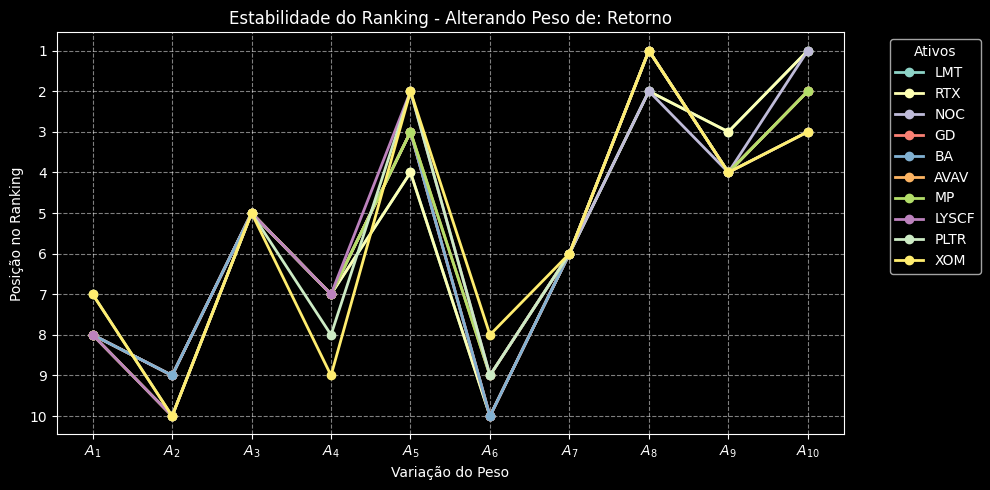


Análise de Sensibilidade: Volatilidade (C2)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       8 |      8 |     8 |
| $A_{2}$           |    10 |    10 |    10 |   10 |   10 |      9 |    9 |       9 |      9 |     9 |
| $A_{3}$           |     5 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       7 |      7 |     7 |
| $A_{5}$           |     3 |     3 |     3 |    3 |    3 |      3 |    3 |       3 |      3 |     3 |
| $A_{6}$           |     9 |     9 |     9 |    9 |    9 |     10 |   10 |      10 |     10 |    10 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     1 

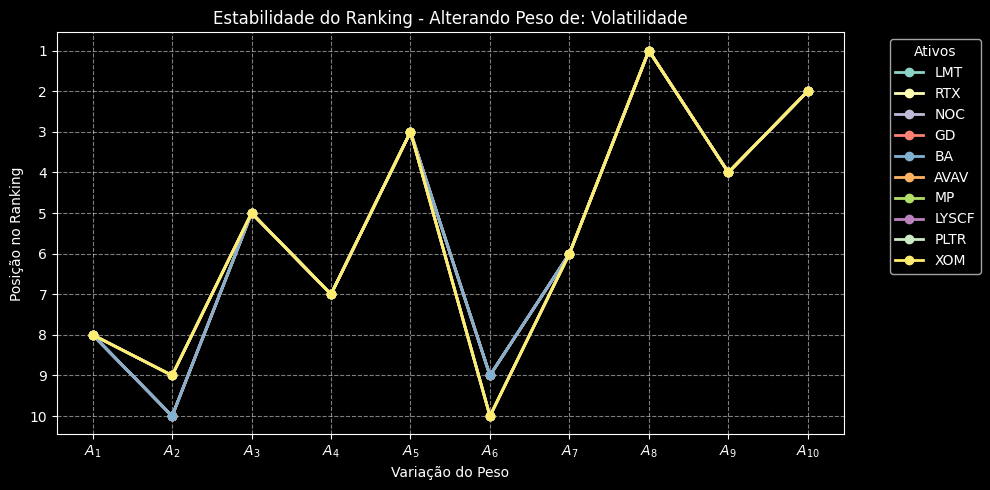


Análise de Sensibilidade: Sharpe (C3)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       8 |      7 |     7 |
| $A_{2}$           |     9 |     9 |     9 |    9 |    9 |     10 |   10 |      10 |     10 |    10 |
| $A_{3}$           |     5 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       7 |      8 |     8 |
| $A_{5}$           |     3 |     3 |     3 |    3 |    3 |      3 |    3 |       3 |      3 |     3 |
| $A_{6}$           |    10 |    10 |    10 |   10 |   10 |      9 |    9 |       9 |      9 |     9 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     1 |     

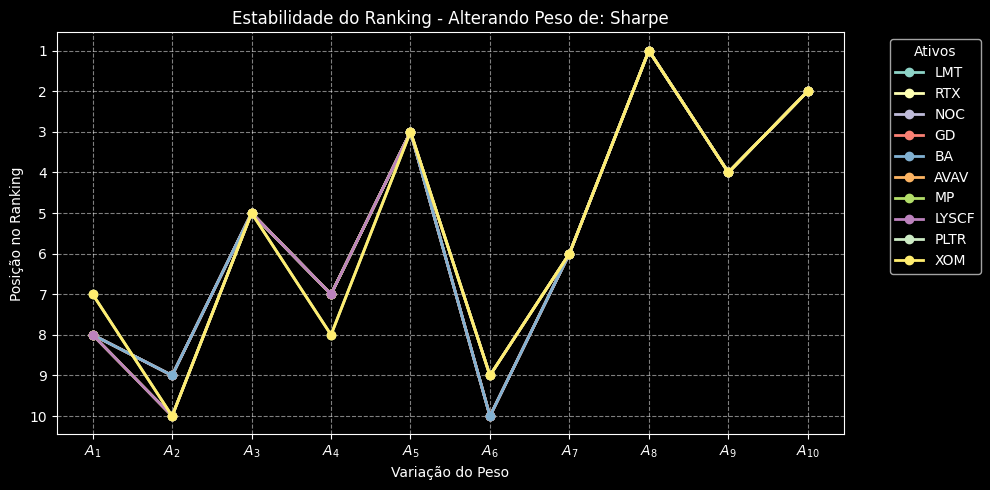


Análise de Sensibilidade: Max Drawdown (C4)
| Peso Modificado   |   LMT |   RTX |   NOC |   GD |   BA |   AVAV |   MP |   LYSCF |   PLTR |   XOM |
|-------------------|-------|-------|-------|------|------|--------|------|---------|--------|-------|
| $A_{1}$           |     8 |     8 |     8 |    8 |    8 |      8 |    8 |       8 |      8 |     8 |
| $A_{2}$           |    10 |    10 |    10 |   10 |    9 |      9 |    9 |       9 |      9 |     9 |
| $A_{3}$           |     5 |     5 |     5 |    5 |    5 |      5 |    5 |       5 |      5 |     5 |
| $A_{4}$           |     7 |     7 |     7 |    7 |    7 |      7 |    7 |       7 |      7 |     7 |
| $A_{5}$           |     3 |     3 |     3 |    3 |    3 |      3 |    3 |       3 |      3 |     3 |
| $A_{6}$           |     9 |     9 |     9 |    9 |   10 |     10 |   10 |      10 |     10 |    10 |
| $A_{7}$           |     6 |     6 |     6 |    6 |    6 |      6 |    6 |       6 |      6 |     6 |
| $A_{8}$           |     1 

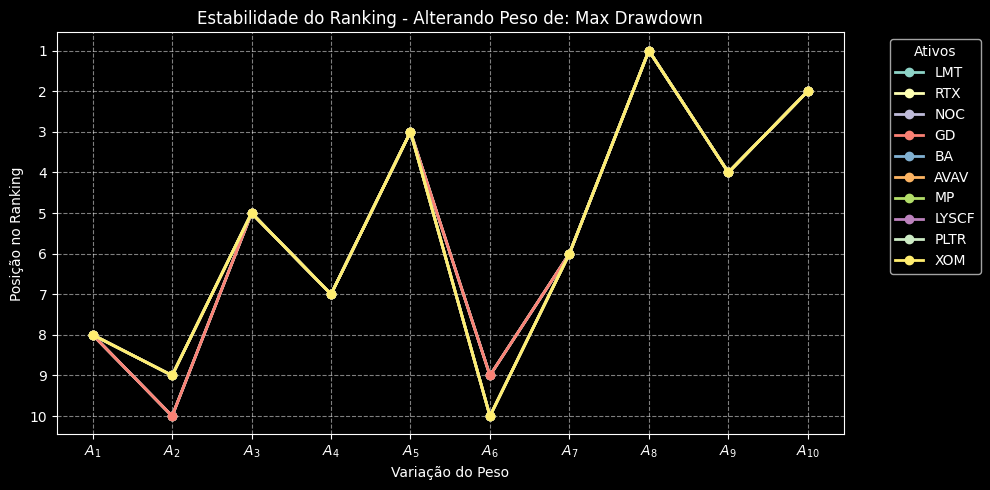


Análise de Sensibilidade concluída com sucesso!


In [10]:
# --- BLOCO DE ANÁLISE DE SENSIBILIDADE (AJUSTADO E CORRIGIDO) ---
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pyrepo_mcda.sensitivity_analysis_weights_percentages import Sensitivity_analysis_weights_percentages
from pyrepo_mcda.mcda_methods import TOPSIS

# IMPORTANTE: Definindo os apelidos que faltavam
from pyrepo_mcda import normalizations as norms
from pyrepo_mcda import distance_metrics as dists

# 1. Parâmetros de Sensibilidade
percentages = np.arange(0.05, 0.55, 0.1)

# Agora o 'norms' e 'dists' estão definidos corretamente
method = TOPSIS(normalization_method=norms.minmax_normalization, distance_metric=dists.euclidean)
sensitivity_analysis = Sensitivity_analysis_weights_percentages()

# Nomes dos critérios para facilitar a leitura
list_crit_names = ['Retorno', 'Volatilidade', 'Sharpe', 'Max Drawdown']

# Dicionário para armazenar resumos de sensibilidade para o relatório final
sens_summary_for_ai = {}

# 2. Execução da Análise de Sensibilidade
for j in range(matrix.shape[1]):
    # Executa a análise para o critério j
    data_sens = sensitivity_analysis(matrix, weights, types, percentages, method, j, [-1, 1])

    # Prepara o cabeçalho
    header = ["Peso Modificado"] + list(tickers)

    print(f'\n' + '='*60)
    print(f'Análise de Sensibilidade: {list_crit_names[j]} (C{j+1})')
    print('='*60)

    # Exibe a tabela
    print(tabulate(data_sens, headers=header, tablefmt='github'))

    # Salva o desvio padrão do ranking para a IA saber qual critério é mais instável
    sens_summary_for_ai[list_crit_names[j]] = data_sens.std().mean()

    # 3. Gráfico de Estabilidade
    plt.figure(figsize=(10, 5))
    for i, ticker in enumerate(tickers):
        plt.plot(data_sens.index, data_sens.iloc[:, i], marker='o', label=ticker, linewidth=2)

    plt.gca().invert_yaxis()  # Rank 1 no topo é melhor para visualizar
    plt.title(f'Estabilidade do Ranking - Alterando Peso de: {list_crit_names[j]}', fontsize=12)
    plt.xlabel('Variação do Peso', fontsize=10)
    plt.ylabel('Posição no Ranking', fontsize=10)
    plt.yticks(range(1, len(tickers) + 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ativos")
    plt.tight_layout()
    plt.show()

print("\nAnálise de Sensibilidade concluída com sucesso!")


----------------------------------------
GRÁFICOS DE APOIO: Retorno
----------------------------------------


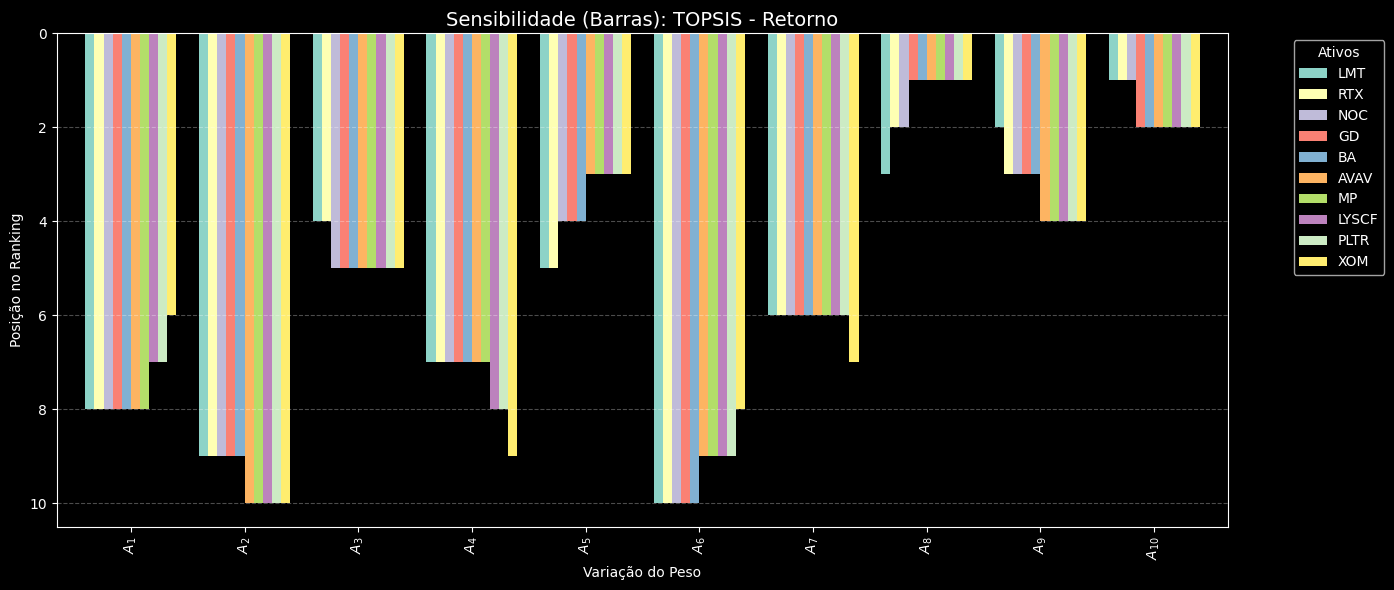

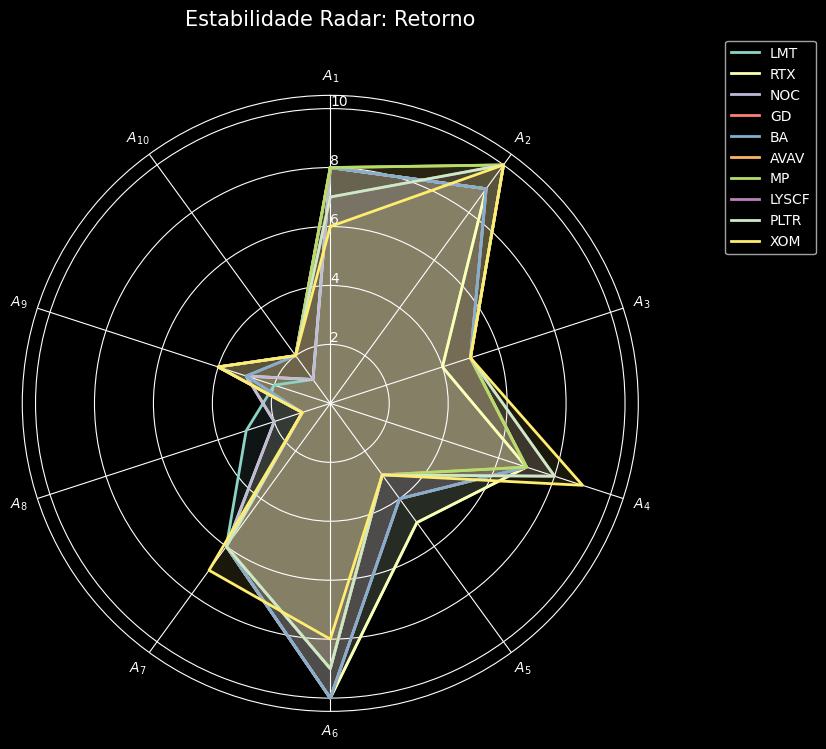


----------------------------------------
GRÁFICOS DE APOIO: Volatilidade
----------------------------------------


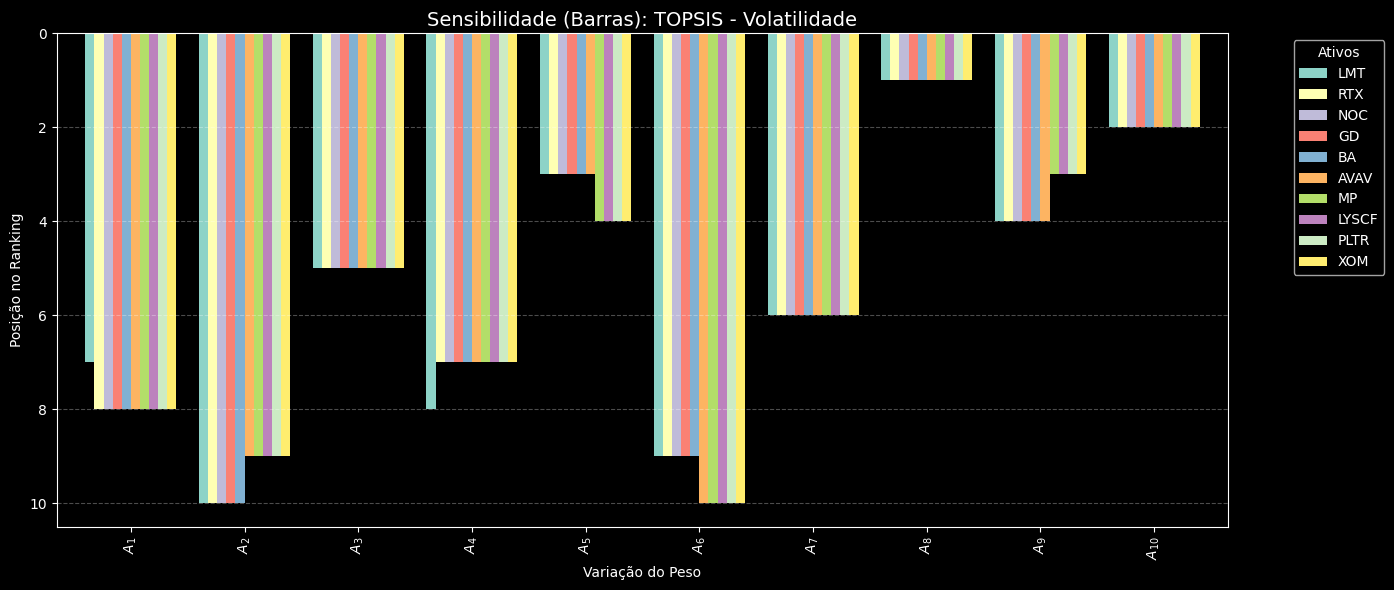

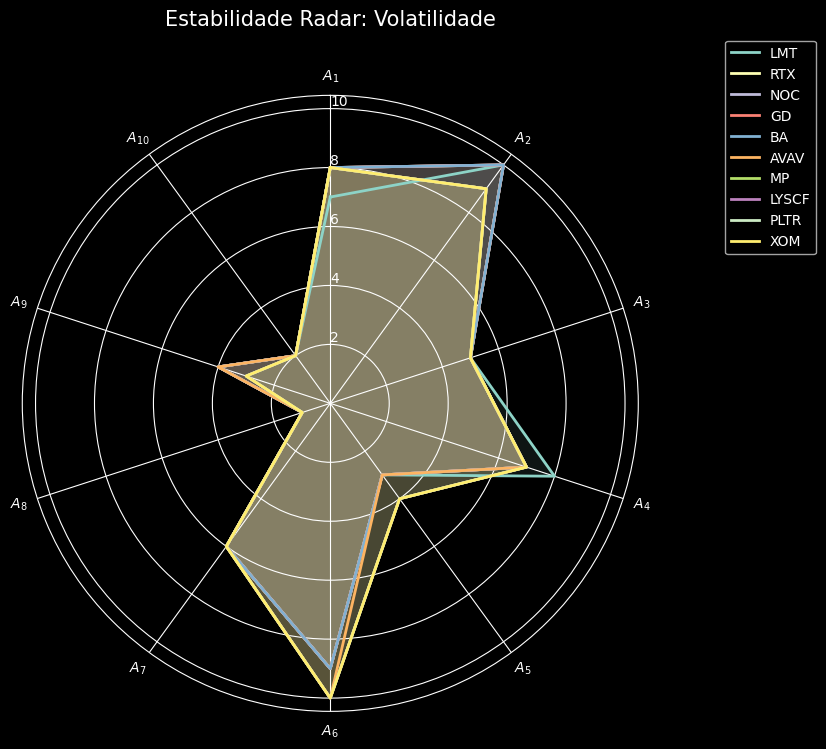


----------------------------------------
GRÁFICOS DE APOIO: Sharpe
----------------------------------------


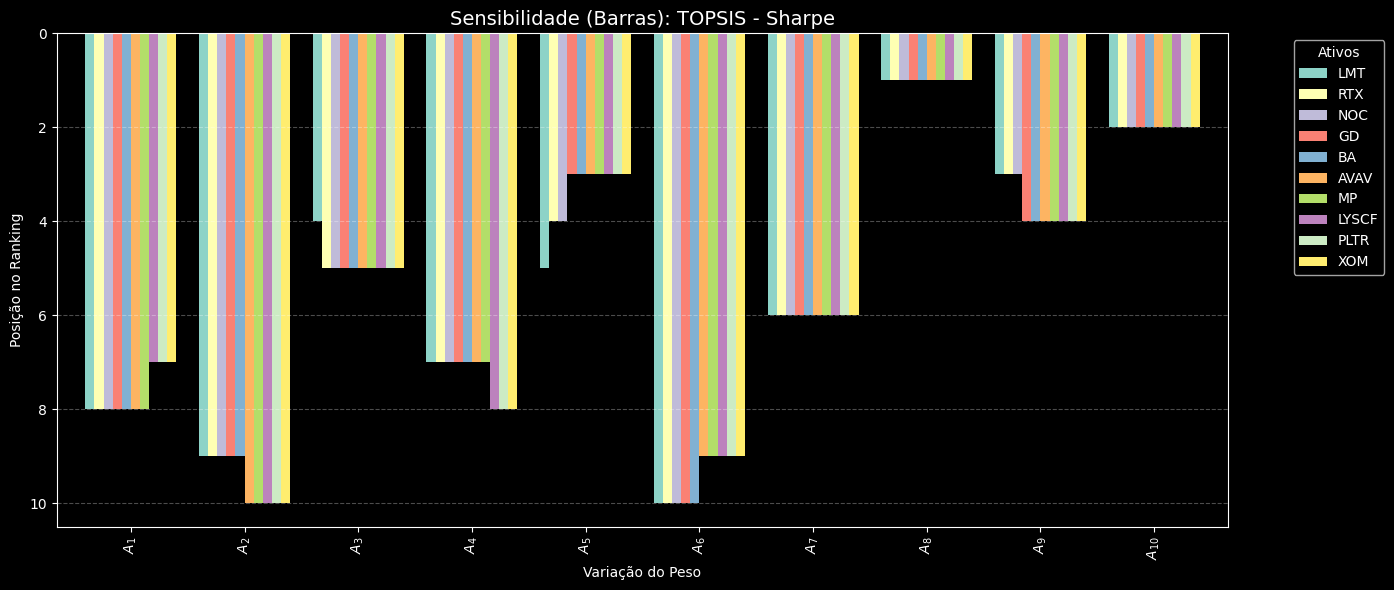

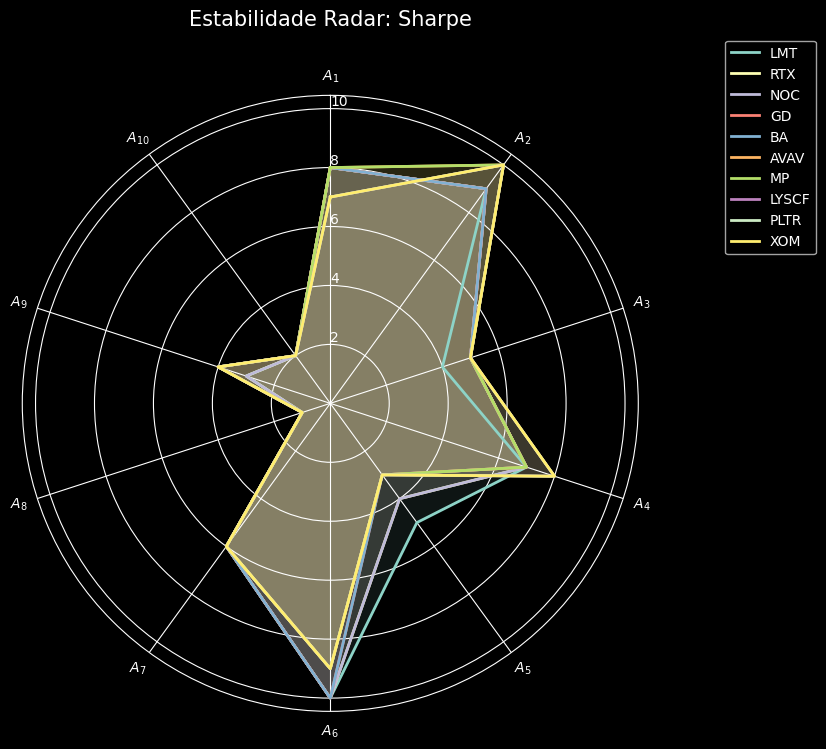


----------------------------------------
GRÁFICOS DE APOIO: Max Drawdown
----------------------------------------


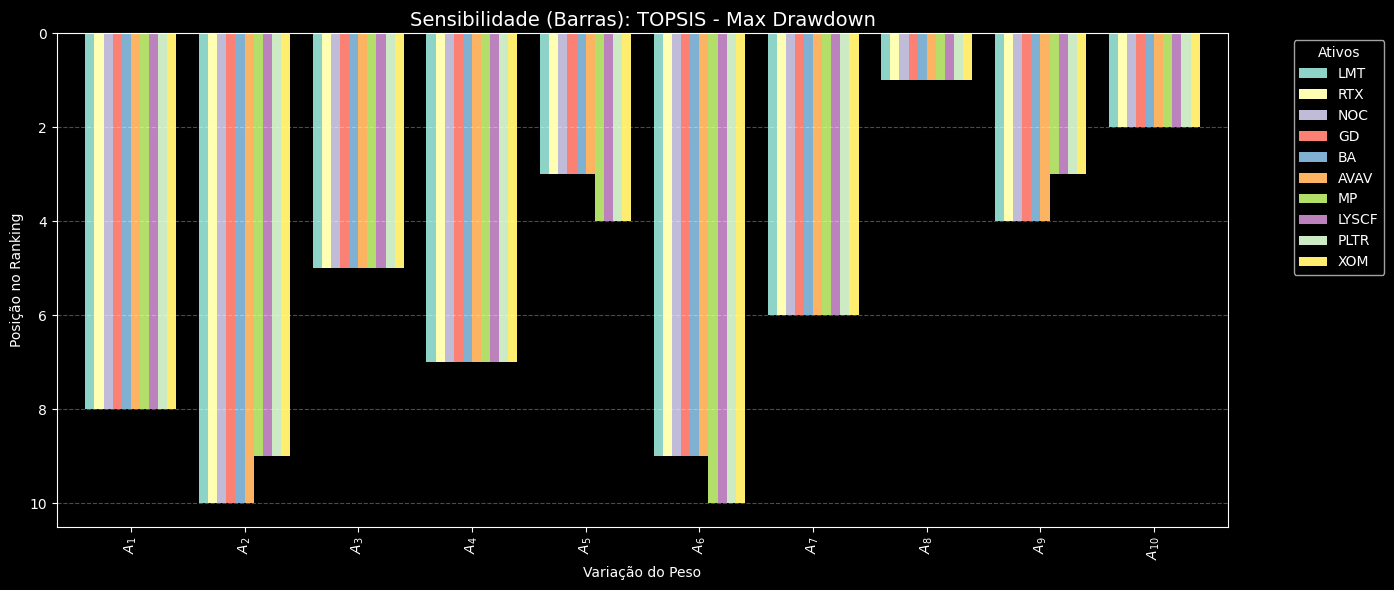

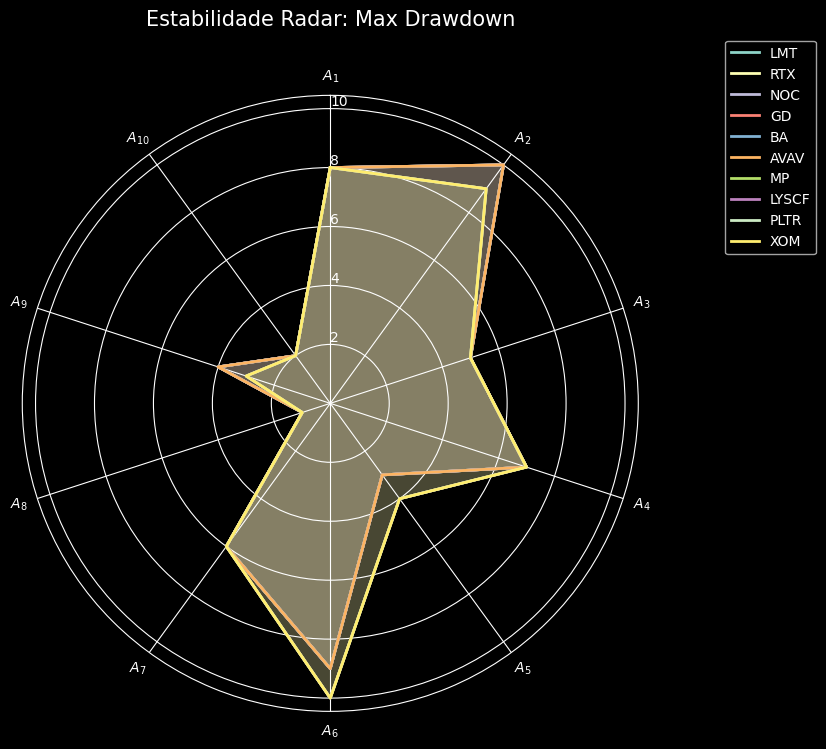

In [ ]:
# --- BLOCO: VISUALIZAÇÕES DE BARRAS E RADAR ---
import math

def plot_barplot_sensitivity(data, method_name, crit_name):
    """Gera gráfico de barras para análise de sensibilidade."""
    # Plotando os rankings; quanto menor a barra, melhor a posição
    ax = data.plot(kind='bar', figsize=(14, 6), width=0.8)
    plt.title(f'Sensibilidade (Barras): {method_name} - {crit_name}', fontsize=14)
    plt.xlabel('Variação do Peso')
    plt.ylabel('Posição no Ranking')
    plt.gca().invert_yaxis()  # Rank 1 no topo
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ativos")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_radar(data, title):
    """Gera gráfico de radar para estabilidade do ranking."""
    categories = data.index.astype(str).tolist()
    N = len(categories)

    # Define os ângulos para cada eixo do radar
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1] # Fecha o círculo

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    for ticker in data.columns:
        values = data[ticker].tolist()
        values += values[:1] # Fecha o polígono
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=ticker)
        # Preenchimento sólido para evitar problemas de transparência em alguns backends
        ax.fill(angles, values, alpha=0.1)

    # Configurações do gráfico de Radar
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)

    # No Radar de Ranking, quanto mais perto do centro (centro = 1), melhor o ativo
    plt.title(title, size=15, color='white', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- EXECUÇÃO DAS VISUALIZAÇÕES ---
# O j loop assume que 'matrix' e 'sensitivity_analysis' estão no contexto do Jupyter
for j in range(matrix.shape[1]):
    # data_sens gerado conforme a documentação da pyrepo-mcda
    data_sens = sensitivity_analysis(matrix, weights, types, percentages, method, j, [-1, 1])
    data_sens.columns = tickers # Aplica os nomes dos ativos de guerra/estratégia

    print(f"\n" + "-"*40)
    print(f"GRÁFICOS DE APOIO: {list_crit_names[j]}")
    print("-"*40)

    # 1. Gráfico de Barras
    plot_barplot_sensitivity(data_sens, method.__class__.__name__, list_crit_names[j])

    # 2. Gráfico de Radar
    plot_radar(data_sens, f'Estabilidade Radar: {list_crit_names[j]}')


EXECUTANDO TOPSIS COM MÚLTIPLAS MÉTRICAS DE DISTÂNCIA
|       |   Euclidean |   Manhattan |   Hausdorff |   Chebyshev |   Bray curtis |   Canberra |   Lorentzian |   Jaccard |
|-------|-------------|-------------|-------------|-------------|---------------|------------|--------------|-----------|
| LMT   |           8 |           8 |           8 |           8 |             8 |          7 |            8 |         7 |
| RTX   |          10 |           9 |           9 |          10 |             9 |         10 |            9 |        10 |
| NOC   |           5 |           4 |           5 |           5 |             4 |          3 |            4 |         5 |
| GD    |           7 |           7 |           7 |           7 |             7 |          6 |            7 |         8 |
| BA    |           3 |           5 |           2 |           3 |             5 |          5 |            5 |         3 |
| AVAV  |           9 |          10 |          10 |           9 |            10 |          

<Figure size 1200x600 with 0 Axes>

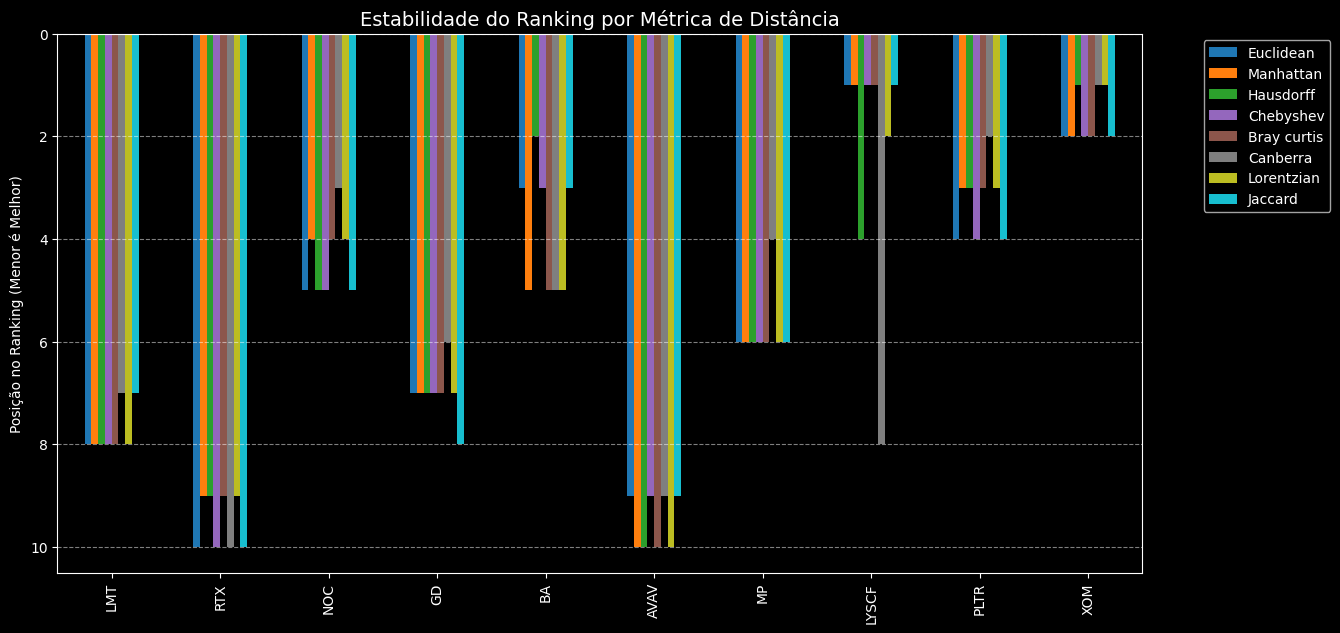

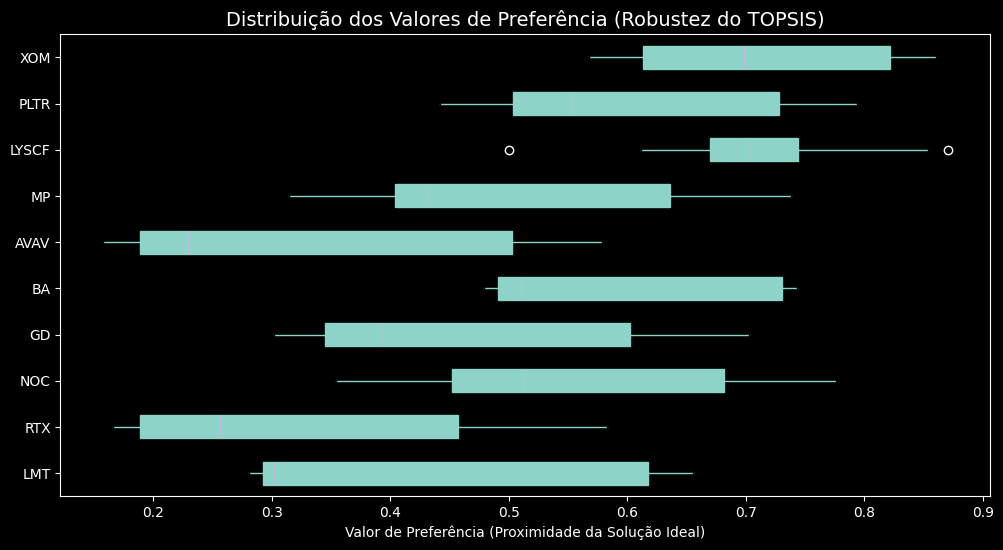

In [ ]:
# --- BLOCO: ANÁLISE COMPARATIVA DE MÉTRICAS DE DISTÂNCIA ---
from pyrepo_mcda import distance_metrics as dists

# 1. Lista de métricas de distância para teste de robustez
distance_metrics = [
    dists.euclidean,    # Padrão: linha reta
    dists.manhattan,    # Distância em quarteirões
    dists.hausdorff,    # Mede a maior distância entre conjuntos
    dists.chebyshev,    # Foca no critério com maior discrepância
    dists.bray_curtis,  # Comum em ecologia e séries temporais
    dists.canberra,     # Sensível a valores próximos de zero
    dists.lorentzian,   # Menos sensível a outliers
    dists.jaccard       # Útil para medir similaridade
]

# 2. Inicialização dos DataFrames para coletar resultados
# tickers foi definido anteriormente com ativos como LMT, RTX, NVDA, etc.
df_preferences = pd.DataFrame(index = tickers)
df_rankings = pd.DataFrame(index = tickers)

print("\n" + "="*60)
print("EXECUTANDO TOPSIS COM MÚLTIPLAS MÉTRICAS DE DISTÂNCIA")
print("="*60)

# 3. Loop de execução comparativa
for distance_metric in distance_metrics:
    # Cria o objeto TOPSIS variando apenas a métrica de distância
    topsis = TOPSIS(normalization_method = norms.minmax_normalization, distance_metric = distance_metric)

    # matrix, weights e types devem estar carregados no contexto
    pref = topsis(matrix, weights, types)
    rank = rank_preferences(pref, reverse = True)

    # Formata o nome da métrica para as colunas do DataFrame
    metric_name = distance_metric.__name__.capitalize().replace('_', ' ')
    df_preferences[metric_name] = pref
    df_rankings[metric_name] = rank

# Exibe o DataFrame de Rankings para comparação visual rápida
print(tabulate(df_rankings, headers='keys', tablefmt='github'))

# 4. Visualização de Resultados
# Gráfico de Barras para os Rankings
plt.figure(figsize=(12, 6))
df_rankings.plot(kind='bar', figsize=(14, 7), colormap='tab10')
plt.title('Estabilidade do Ranking por Métrica de Distância', fontsize=14)
plt.ylabel('Posição no Ranking (Menor é Melhor)')
plt.gca().invert_yaxis() # Rank 1 no topo
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Gráfico de Caixa (Boxplot) para Distribuição de Preferências
# Ajuda a ver a dispersão das notas dadas a cada ativo
plt.figure(figsize=(12, 6))
df_preferences.T.boxplot(grid=False, vert=False, patch_artist=True)
plt.title('Distribuição dos Valores de Preferência (Robustez do TOPSIS)', fontsize=14)
plt.xlabel('Valor de Preferência (Proximidade da Solução Ideal)')
plt.show()

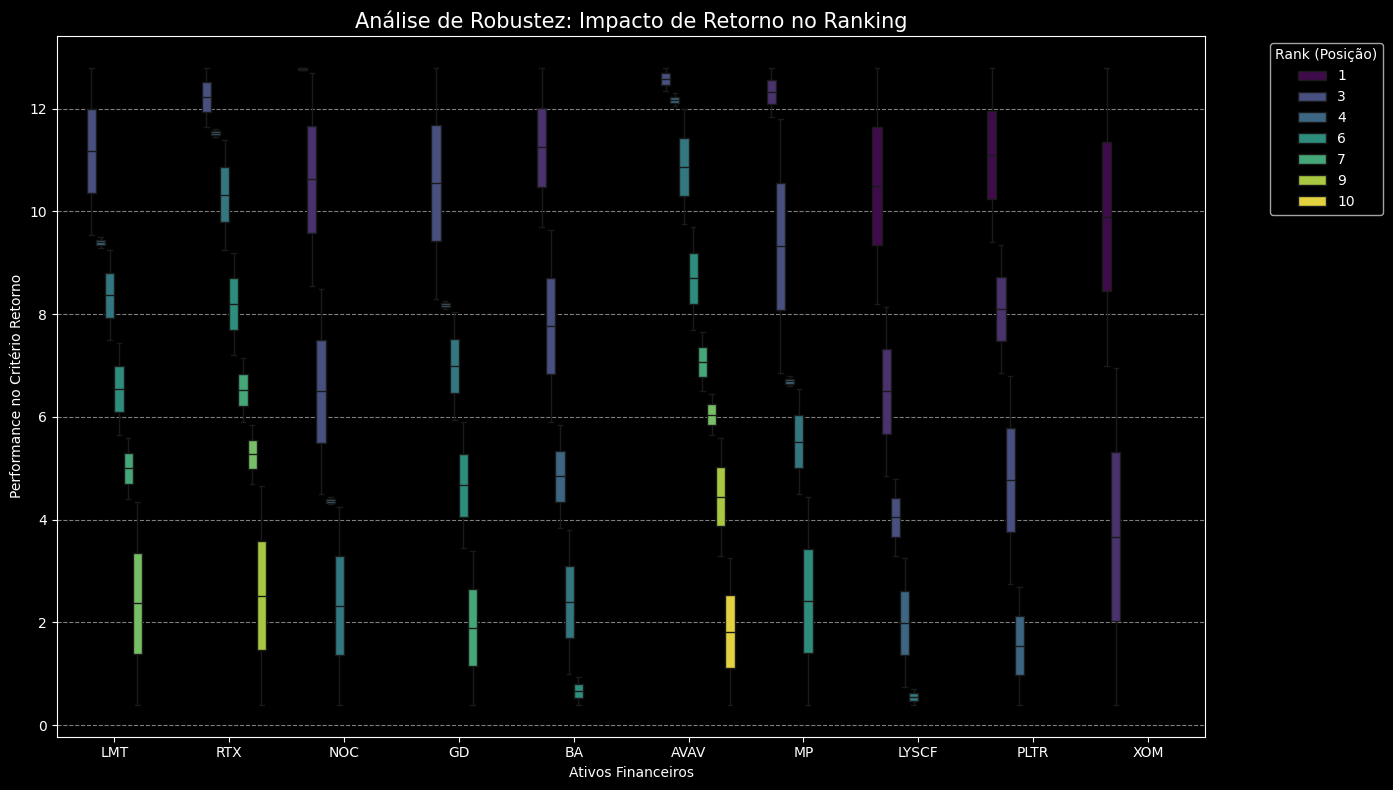

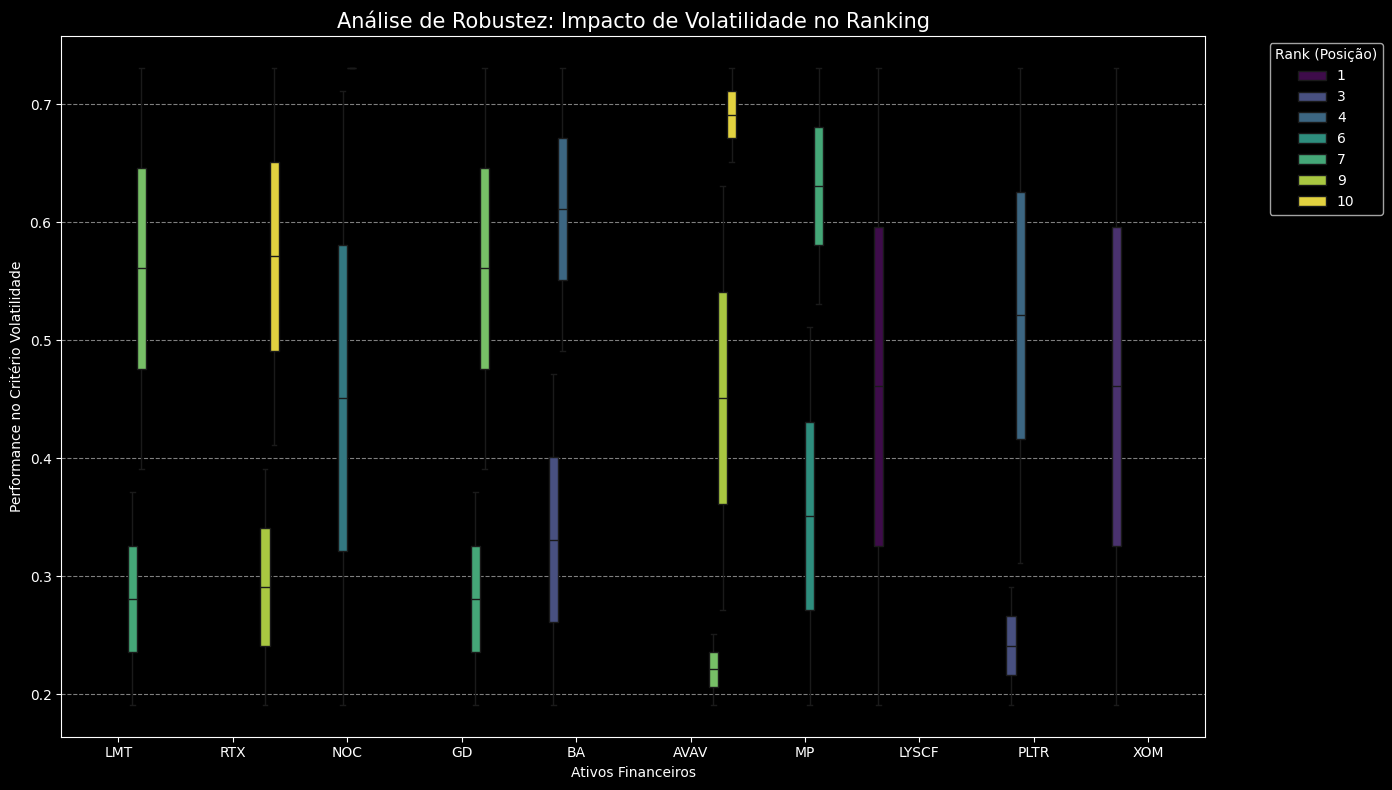

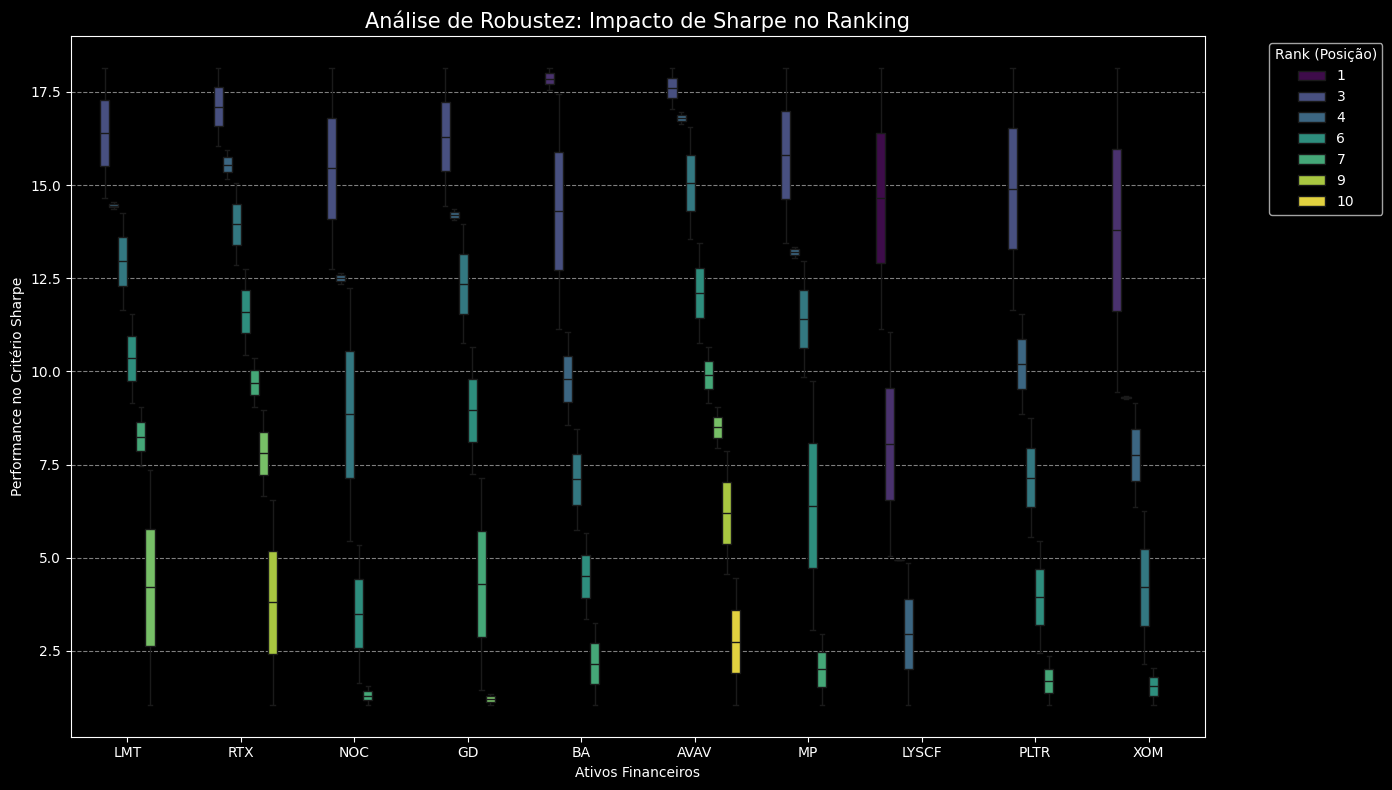

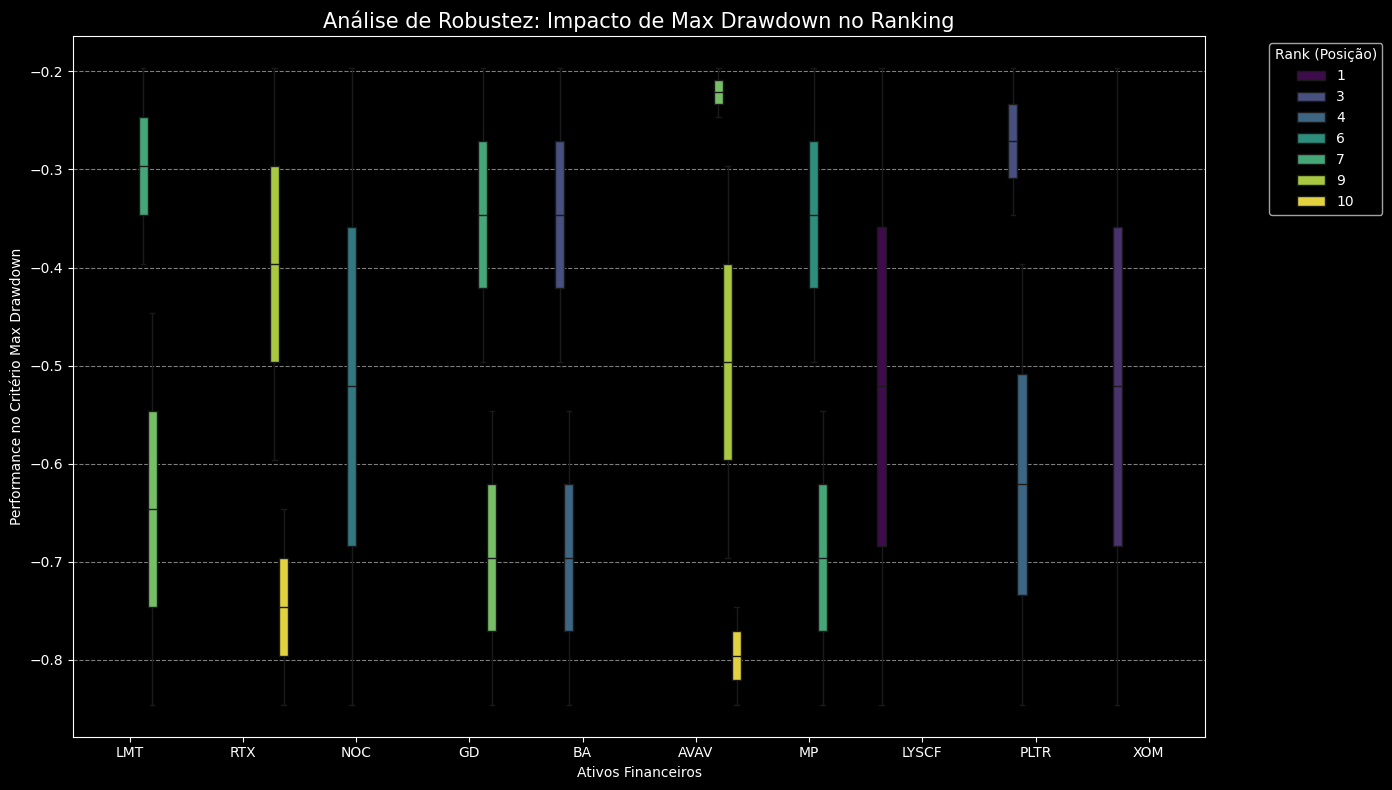

In [ ]:
# --- BLOCO: ANÁLISE DE ROBUSTEZ (SIMULAÇÃO DE PERFORMANCE) ---
import copy
import seaborn as sns

# 1. Configuração do Ambiente de Simulação
topsis = TOPSIS(normalization_method=norms.minmax_normalization, distance_metric=dists.euclidean)

# Definição dos limites (Bounds) baseados na matriz de mercado atual
bounds_min = np.amin(matrix, axis=0)
bounds_max = np.amax(matrix, axis=0)
bounds = np.vstack((bounds_min, bounds_max))

# Identificação das Soluções Ideal (ISP) e Anti-Ideal (ASP)
isp = np.zeros(matrix.shape[1])
isp[types == 1] = bounds[1, types == 1]
isp[types == -1] = bounds[0, types == -1]

asp = np.zeros(matrix.shape[1])
asp[types == 1] = bounds[0, types == 1]
asp[types == -1] = bounds[1, types == -1]

# 2. Definição do Passo de Simulação para cada Critério
# Ajustado para os valores reais (Retorno, Volatilidade, Sharpe, MDD)
# j: passo_da_simulação
indexes = {
    0 : 0.05,  # Passo para Retorno (5%)
    1 : 0.02,  # Passo para Volatilidade (2%)
    2 : 0.1,   # Passo para Sharpe
    3 : 0.05   # Passo para Max Drawdown
}

def plot_boxplot_simulation(df, x_col, y_col, hue_col, xlabel, ylabel, title, filename):
    """Gera visualização de robustez similar ao exemplo visualizations.py"""
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=x_col, y=y_col, hue=hue_col, data=df, palette='viridis')
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Rank (Posição)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 3. Execução da Simulação por Critério
for j in range(matrix.shape[1]):
    change_val = indexes[j]
    dict_results_sim = {'Rank': [], 'Performance': [], 'Alternative': []}

    for i in range(matrix.shape[0]):
        # Gera o vetor de simulação do ponto mais baixo ao mais alto do mercado
        vec = np.arange(asp[j], isp[j] + (types[j] * change_val), types[j] * change_val)

        for v in vec:
            new_matrix = copy.deepcopy(matrix)
            new_matrix[i, j] = v
            pref = topsis(new_matrix, weights, types)
            rank = rank_preferences(pref, reverse=True)

            dict_results_sim['Rank'].append(rank[i])
            dict_results_sim['Performance'].append(v)
            dict_results_sim['Alternative'].append(tickers[i])

    df_results_sim = pd.DataFrame(dict_results_sim)

    # Visualização da Robustez
    plot_boxplot_simulation(
        df_results_sim,
        'Alternative',
        'Performance',
        'Rank',
        'Ativos Financeiros',
        f'Performance no Critério {list_crit_names[j]}',
        f'Análise de Robustez: Impacto de {list_crit_names[j]} no Ranking',
        f'robustness_{j+1}'
    )

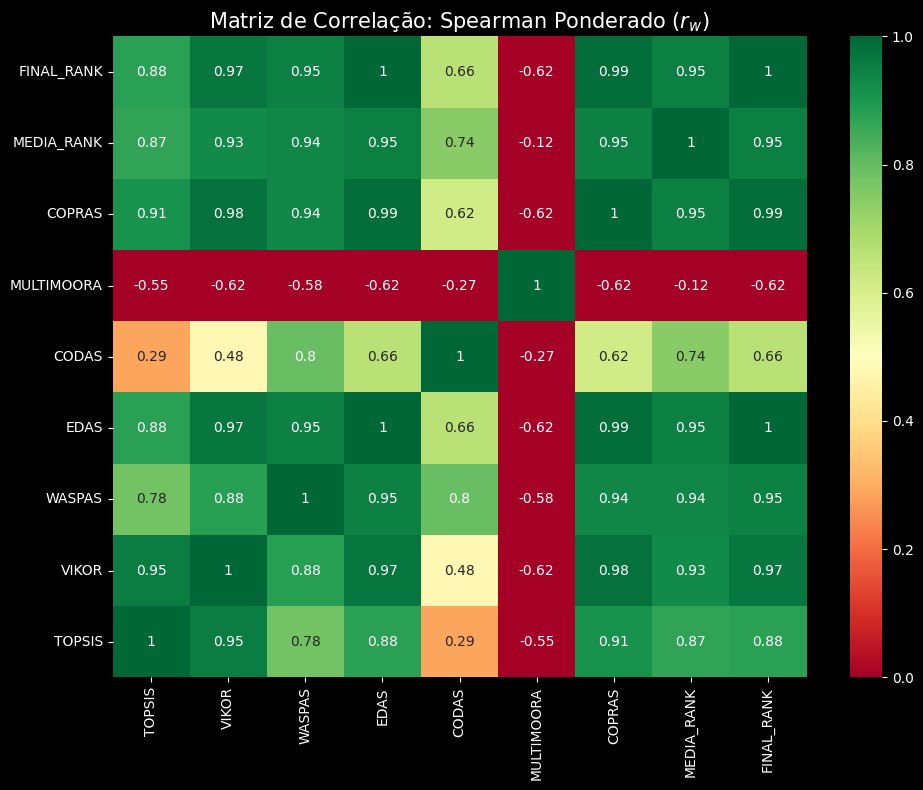

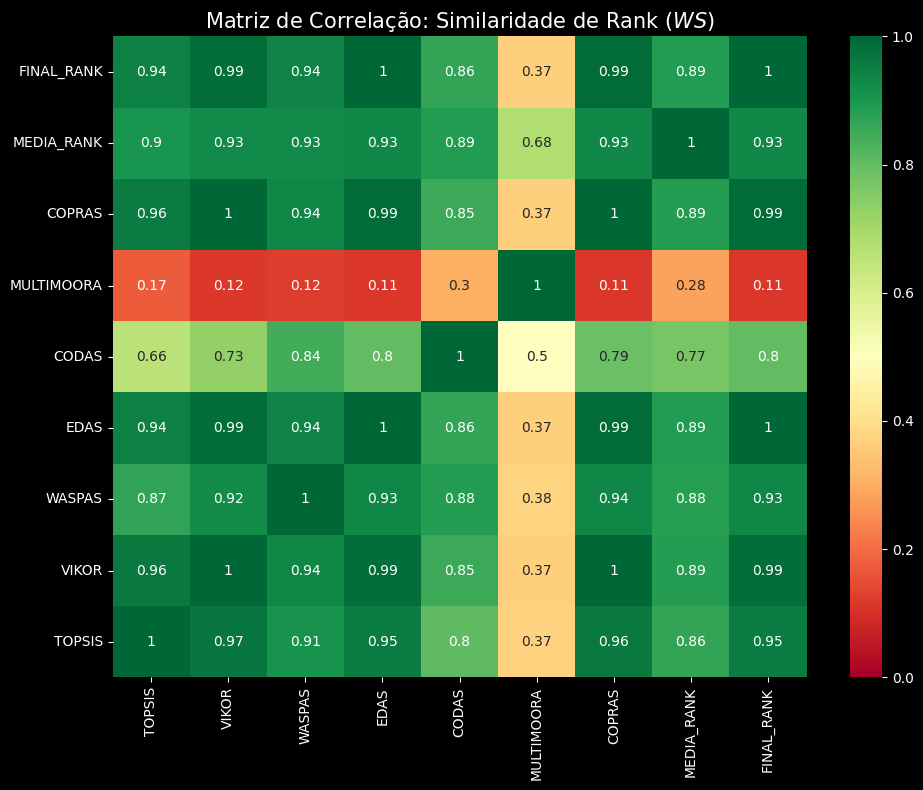

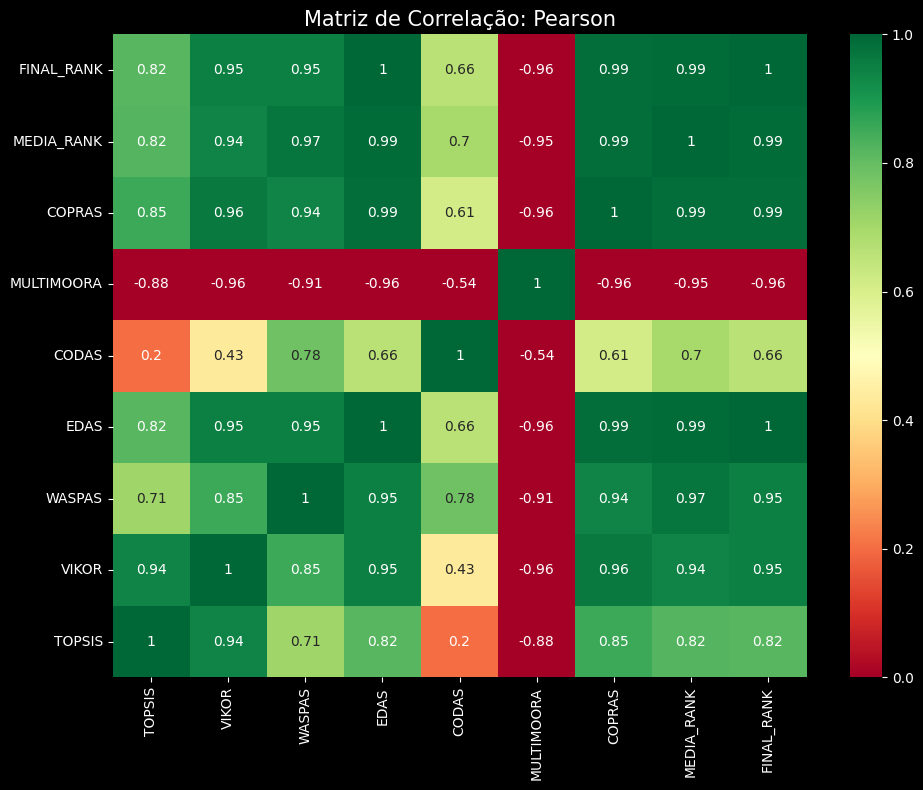

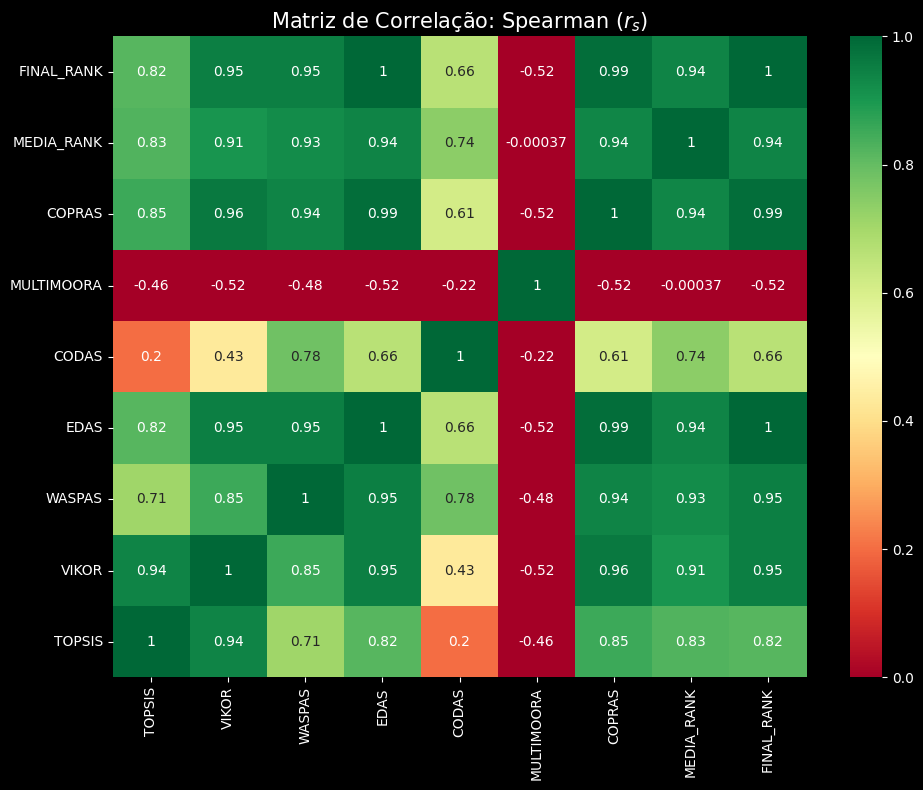

In [ ]:
# --- BLOCO: CORRELAÇÕES DE RESULTADOS E MAPAS DE CALOR ---
import copy
import seaborn as sns
from pyrepo_mcda import correlations as corrs

# 1. Preparação dos dados de ranking
# 'df_ranks' contém os rankings de todos os métodos (TOPSIS, VIKOR, etc.)
data = copy.deepcopy(df_ranks)
method_types = list(data.columns)

# Dicionários para armazenar as matrizes de correlação
dict_rw = {el: [] for el in method_types}
dict_ws = {el: [] for el in method_types}
dict_pearson = {el: [] for el in method_types}
dict_spearman = {el: [] for el in method_types}

# 2. Cálculo das Correlações entre os pares de métodos
for i, j in [(i, j) for i in method_types[::-1] for j in method_types]:
    dict_rw[j].append(corrs.weighted_spearman(data[i], data[j]))
    dict_ws[j].append(corrs.WS_coeff(data[i], data[j]))
    dict_pearson[j].append(corrs.pearson_coeff(data[i], data[j]))
    dict_spearman[j].append(corrs.spearman(data[i], data[j]))

# Transformação em DataFrames para visualização
df_rw = pd.DataFrame(dict_rw, index=method_types[::-1])
df_ws = pd.DataFrame(dict_ws, index=method_types[::-1])
df_pearson = pd.DataFrame(dict_pearson, index=method_types[::-1])
df_spearman = pd.DataFrame(dict_spearman, index=method_types[::-1])

# 3. Função para desenhar os Mapas de Calor (Heatmaps)
def draw_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='RdYlGn', vmin=0, vmax=1)
    plt.title(f'Matriz de Correlação: {title}', fontsize=15)
    plt.tight_layout()
    plt.show()

# 4. Visualização dos Heatmaps
draw_heatmap(df_rw, r'Spearman Ponderado ($r_w$)')
draw_heatmap(df_ws, r'Similaridade de Rank ($WS$)')
draw_heatmap(df_pearson, r'Pearson')
draw_heatmap(df_spearman, r'Spearman ($r_s$)')

# Task
Consolidar todos os dados e gráficos gerados no notebook (matriz de decisão, ranking final do MCDA, gráficos de convergência, tabelas e gráficos das análises de sensibilidade, robustez e correlações) em um único relatório PDF, incluindo descrições textuais para cada seção, e disponibilizá-lo para download.

## Consolidar Dados e Gráficos para o Relatório

### Subtask:
Coletar todos os resultados importantes das análises realizadas e salvar os gráficos gerados como arquivos de imagem para inclusão no PDF.


**Reasoning**:
The subtask requires modifying existing code cells to save plots as image files. I will update the first code block (cell_id: d84692cb-99ea-4923-8752-ff86b2926cbc) to include `plt.savefig()` for the initial ranking plot.



/tmp/ipython-input-502805587.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_prices = yf.download(tickers, period='10y')['Close'].dropna()
[                       0%                       ]

Buscando dados em tempo real para: ['LMT', 'RTX', 'NOC', 'GD', 'BA', 'AVAV', 'MP', 'LYSCF', 'PLTR', 'XOM']...


[*********************100%***********************]  10 of 10 completed



MATRIZ DE DECISÃO (VALORES REAIS DE MERCADO)
        Retorno_Acum  Volatilidade  Sharpe_Ratio  Max_Drawdown
Ticker                                                        
AVAV          3.3354        0.5467        6.1005       -0.6101
BA            0.4146        0.3753        1.1046       -0.5696
GD            1.8762        0.2030        9.2441       -0.2255
LMT           0.9957        0.2229        4.4668       -0.3179
LYSCF         5.7381        0.5241       10.9488       -0.5789
MP            3.2386        0.7308        4.4314       -0.8199
NOC           1.5427        0.2455        6.2849       -0.2228
PLTR         12.6137        0.7053       17.8849       -0.8462
RTX           2.9161        0.2490       11.7107       -0.3284
XOM           4.4836        0.2850       15.7309       -0.2051

Erro no método SPOTIS: boolean index did not match indexed array along axis 1; size of axis is 2 but size of corresponding boolean axis is 4
Erro no método MABAC: module 'numpy' has no attribute 'p

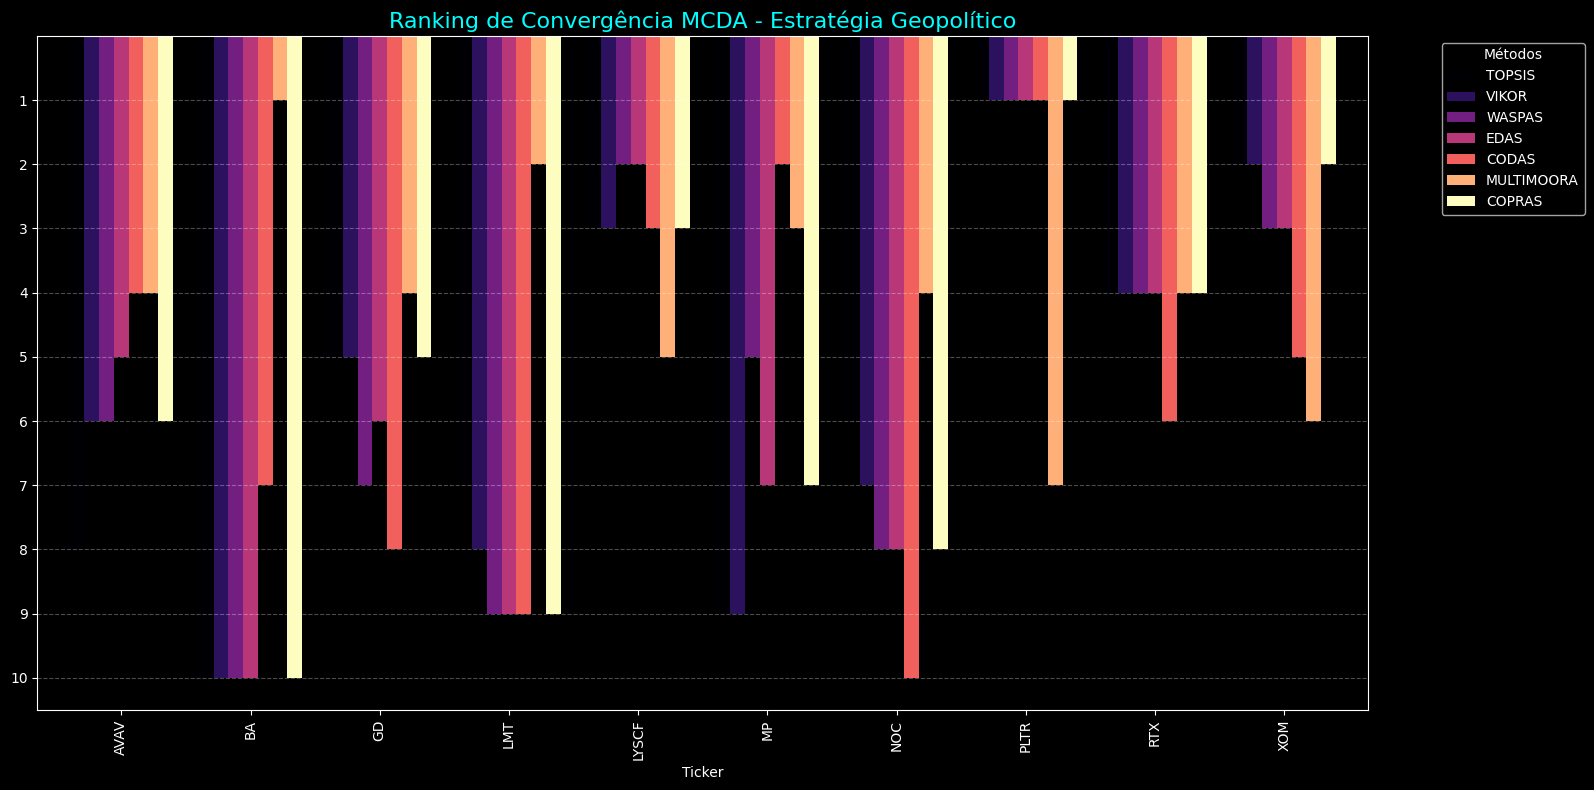


--- RANKING FINAL (CONSENSO GEOPOLÍTICO) ---
Ticker
PLTR      1
LYSCF     2
XOM       3
RTX       4
AVAV      5
GD        6
MP        7
NOC       8
LMT       9
BA       10
Name: FINAL_RANK, dtype: int64


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install pyrepo-mcda
from pyrepo_mcda.mcda_methods import (
    TOPSIS, VIKOR, SPOTIS, WASPAS, MABAC,
    EDAS, CODAS, MULTIMOORA, COPRAS
)
from pyrepo_mcda.additions import rank_preferences

# 1. Definição dos Tickers Estratégicos
tickers = [
    'LMT', 'RTX', 'NOC', 'GD',    # Bélica/Defesa
    'BA', 'AVAV',                 # Espacial/Drones
    'MP', 'LYSCF',                # Terras Raras
    'PLTR', 'XOM'                 # Inteligência/Energia
]

print(f"Buscando dados em tempo real para: {tickers}...")
df_prices = yf.download(tickers, period='10y')['Close'].dropna()

# 2. Cálculo dos Critérios (Construção da Matriz)
returns = df_prices.pct_change().dropna()
c1_ret = (df_prices.iloc[-1] / df_prices.iloc[0]) - 1          # Retorno Acumulado
c2_vol = returns.std() * np.sqrt(252)                         # Volatilidade Anualizada
c3_sha = c1_ret / c2_vol                                      # Índice Sharpe
c4_mdd = (df_prices / df_prices.cummax() - 1).min()            # Max Drawdown

# Criando um DataFrame para a Matriz de Decisão
decision_matrix_df = pd.DataFrame({
    'Retorno_Acum': c1_ret,
    'Volatilidade': c2_vol,
    'Sharpe_Ratio': c3_sha,
    'Max_Drawdown': c4_mdd
}, index=df_prices.columns)

# --- PRINT DA MATRIZ CRIADA ---
print("\n" + "="*70)
print("MATRIZ DE DECISÃO (VALORES REAIS DE MERCADO)")
print("="*70)
print(decision_matrix_df.round(4))
print("="*70 + "\n")

# Convertendo para NumPy para o processamento
matrix = decision_matrix_df.values
weights = np.array([0.35, 0.15, 0.35, 0.15])
# 1 para Maximização, -1 para Minimização
types = np.array([1, -1, 1, 1])

# 3. Configuração de Métodos
methods_config = {
    "TOPSIS": (TOPSIS(), True),
    "VIKOR": (VIKOR(), False),
    "SPOTIS": (SPOTIS(), False),
    "WASPAS": (WASPAS(), True),
    "MABAC": (MABAC(), True),
    "EDAS": (EDAS(), True),
    "CODAS": (CODAS(), True),
    "MULTIMOORA": (MULTIMOORA(), True),
    "COPRAS": (COPRAS(), True)
}

df_ranks = pd.DataFrame(index=decision_matrix_df.index)

# 4. Execução dos Métodos com Correção para o SPOTIS
for name, (method, is_reverse) in methods_config.items():
    try:
        if name == "SPOTIS":
            bounds = np.vstack([
                matrix.min(axis=0),
                matrix.max(axis=0)
            ]).T
            pref = method(matrix, weights, types, bounds)
        else:
            pref = method(matrix, weights, types)

        df_ranks[name] = rank_preferences(pref, reverse=is_reverse)
    except Exception as e:
        print(f"Erro no método {name}: {e}")

# 5. Visualização e Gráfico
plt.style.use('dark_background')
ax = df_ranks.plot(kind='bar', figsize=(16, 8), width=0.8, colormap='magma')
plt.title('Ranking de Convergência MCDA - Estratégia Geopolítico', fontsize=16, color='cyan')
plt.gca().invert_yaxis()
plt.yticks(range(1, len(tickers) + 1))
plt.legend(title='Métodos', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('ranking_convergencia_mcda.png', bbox_inches='tight') # Added savefig
plt.show()

# Resultado Consolidado
df_ranks['MEDIA_RANK'] = df_ranks.mean(axis=1)
df_ranks['FINAL_RANK'] = df_ranks['MEDIA_RANK'].rank().astype(int)
print("\n--- RANKING FINAL (CONSENSO GEOPOLÍTICO) ---")
print(df_ranks['FINAL_RANK'].sort_values())

**Reasoning**:
The subtask requires saving plots as image files. I will modify the functions `plot_barplot_sensitivity` and `plot_radar` in cell `ed67bbcd-8338-4131-94dc-59dcdb2aa4ad` to include `plt.savefig()` before `plt.show()` for each plot generated by these functions.




----------------------------------------
GRÁFICOS DE APOIO: Retorno
----------------------------------------


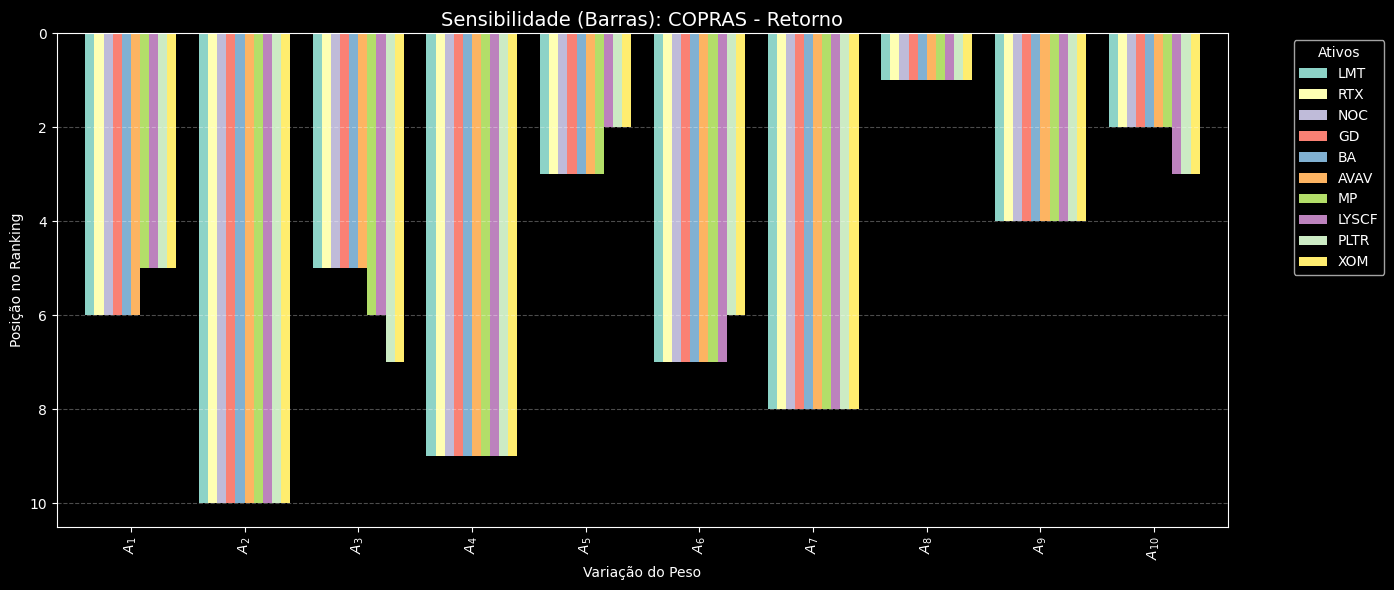

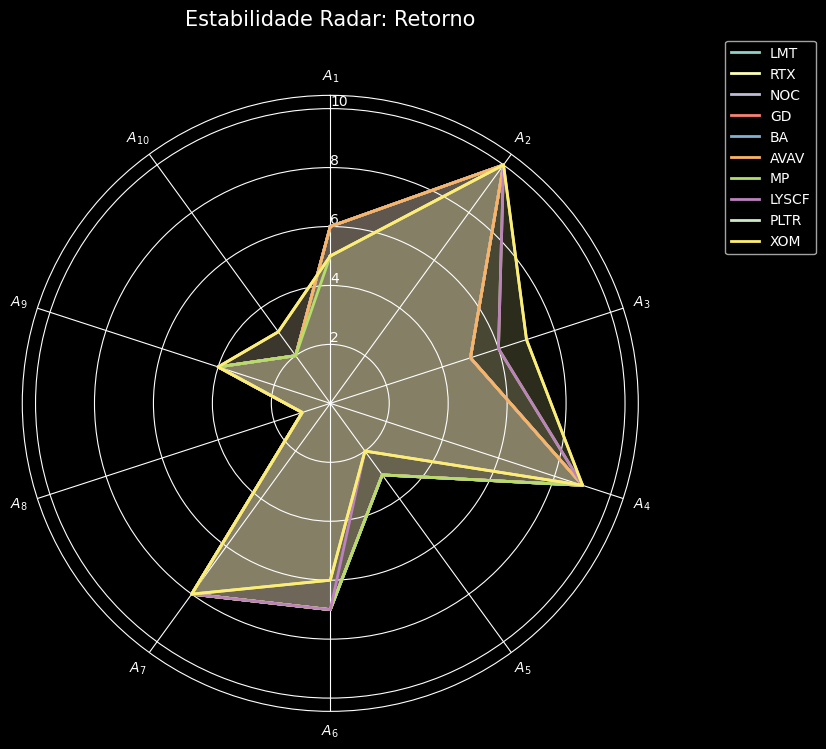


----------------------------------------
GRÁFICOS DE APOIO: Volatilidade
----------------------------------------


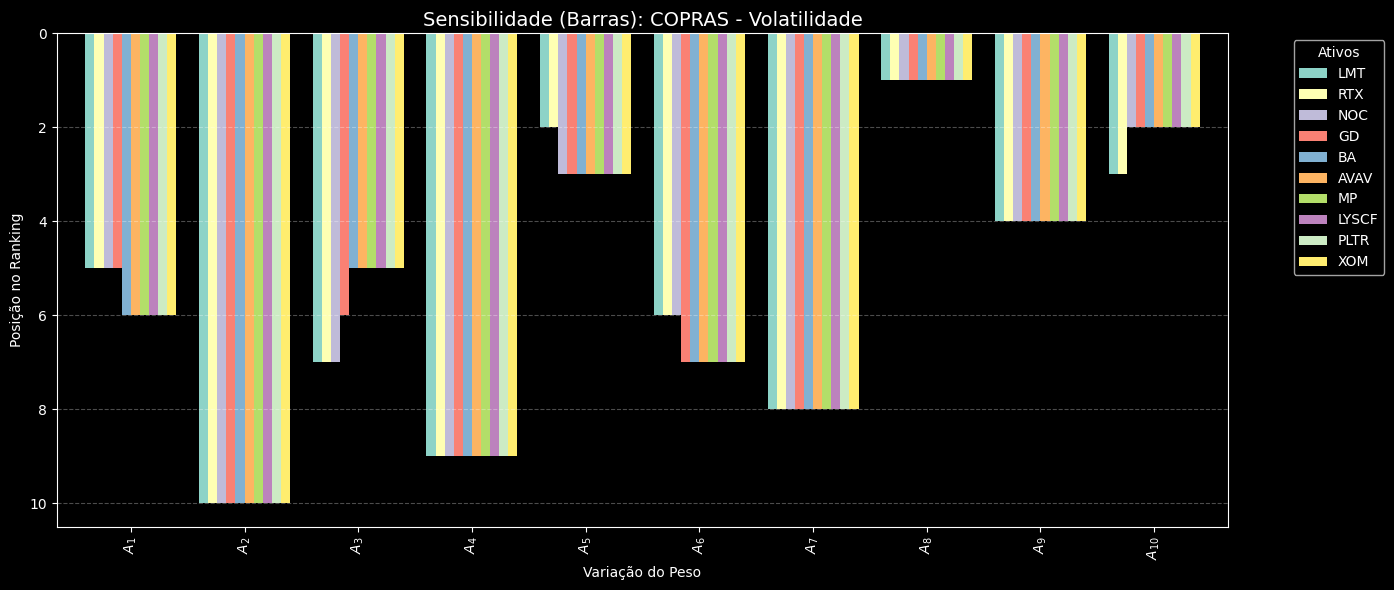

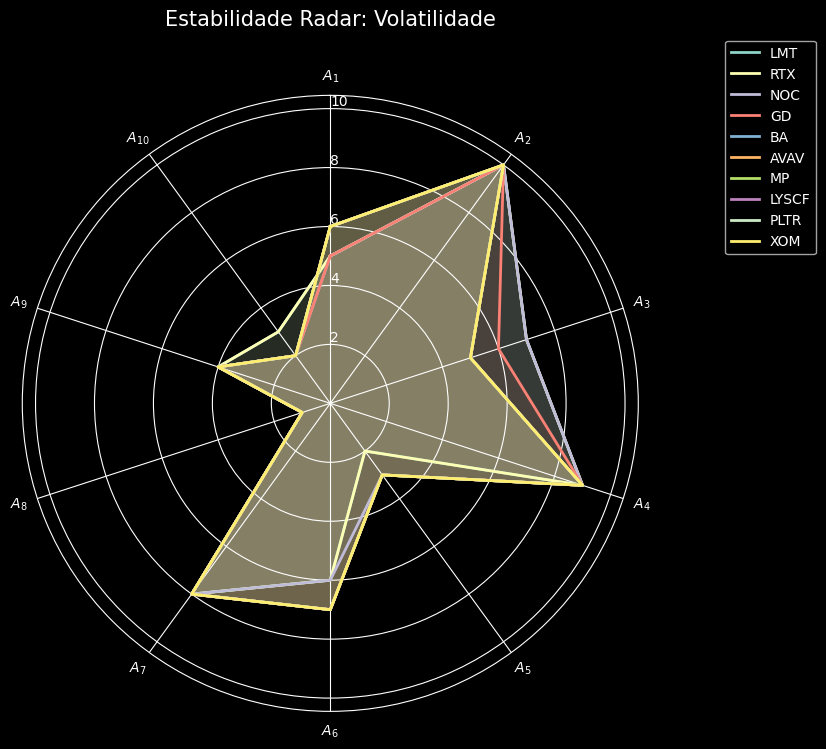


----------------------------------------
GRÁFICOS DE APOIO: Sharpe
----------------------------------------


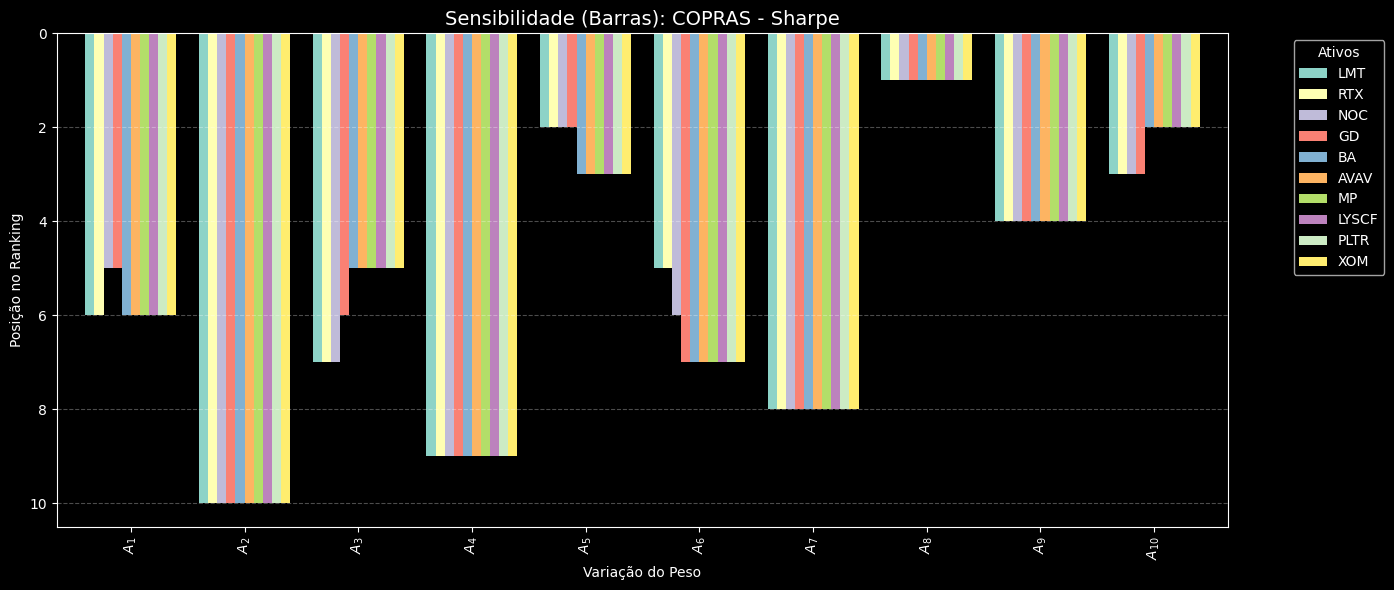

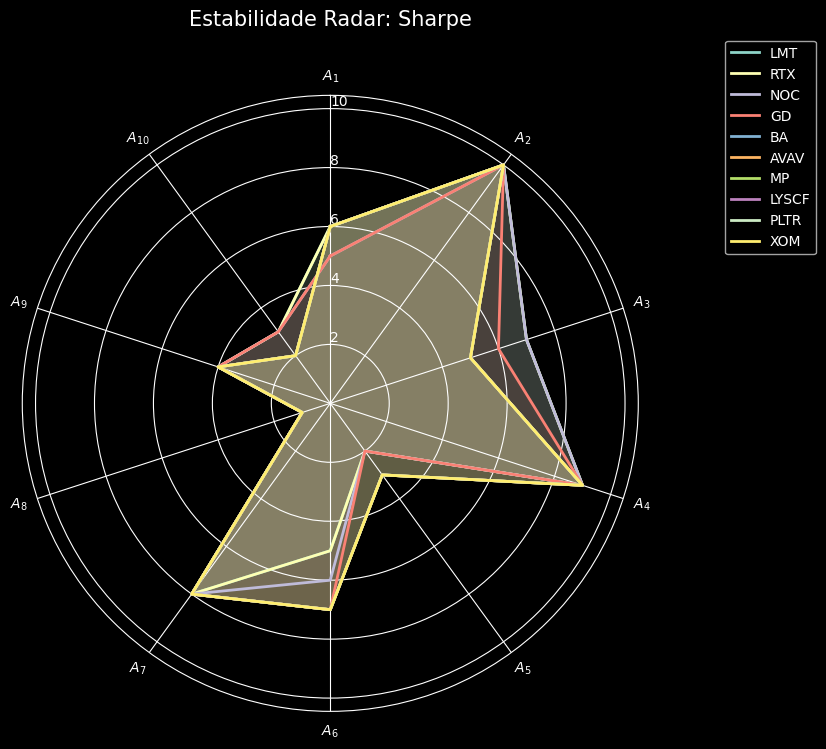


----------------------------------------
GRÁFICOS DE APOIO: Max Drawdown
----------------------------------------


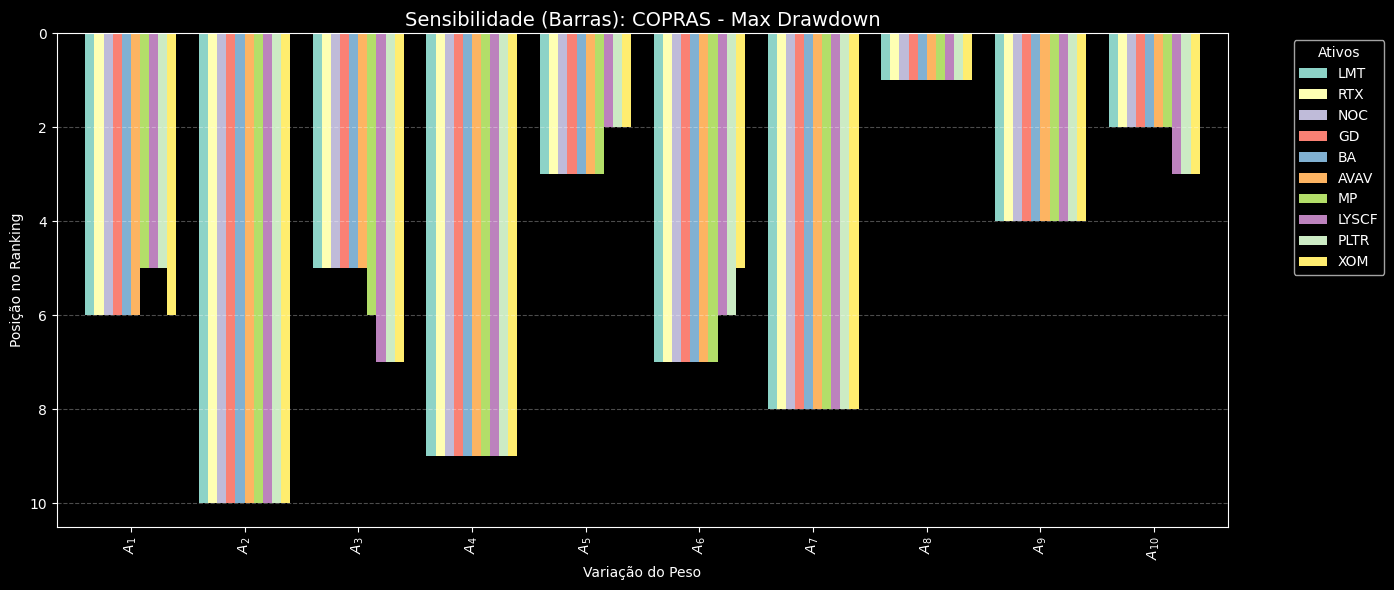

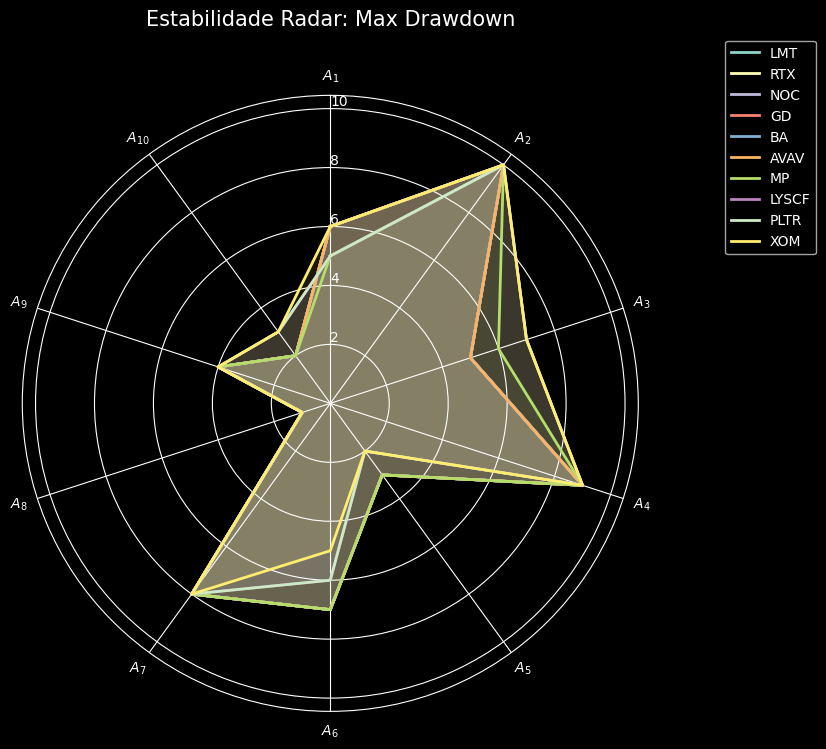

In [ ]:
# --- BLOCO: VISUALIZAÇÕES DE BARRAS E RADAR ---
import math

def plot_barplot_sensitivity(data, method_name, crit_name):
    """Gera gráfico de barras para análise de sensibilidade."""
    # Plotando os rankings; quanto menor a barra, melhor a posição
    ax = data.plot(kind='bar', figsize=(14, 6), width=0.8)
    plt.title(f'Sensibilidade (Barras): {method_name} - {crit_name}', fontsize=14)
    plt.xlabel('Variação do Peso')
    plt.ylabel('Posição no Ranking')
    plt.gca().invert_yaxis()  # Rank 1 no topo
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ativos")
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'bar_sensitivity_{crit_name.replace(' ', '_')}.png', bbox_inches='tight')
    plt.show()

def plot_radar(data, title, crit_name):
    """Gera gráfico de radar para estabilidade do ranking."""
    categories = data.index.astype(str).tolist()
    N = len(categories)

    # Define os ângulos para cada eixo do radar
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1] # Fecha o círculo

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    for ticker in data.columns:
        values = data[ticker].tolist()
        values += values[:1] # Fecha o polígono
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=ticker)
        # Preenchimento sólido para evitar problemas de transparência em alguns backends
        ax.fill(angles, values, alpha=0.1)

    # Configurações do gráfico de Radar
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)

    # No Radar de Ranking, quanto mais perto do centro (centro = 1), melhor o ativo
    plt.title(title, size=15, color='white', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig(f'radar_stability_{crit_name.replace(' ', '_')}.png', bbox_inches='tight')
    plt.show()

# --- EXECUÇÃO DAS VISUALIZAÇÕES ---
# O j loop assume que 'matrix' e 'sensitivity_analysis' estão no contexto do Jupyter
for j in range(matrix.shape[1]):
    # data_sens gerado conforme a documentação da pyrepo-mcda
    data_sens = sensitivity_analysis(matrix, weights, types, percentages, method, j, [-1, 1])
    data_sens.columns = tickers # Aplica os nomes dos ativos de guerra/estratégia

    print(f"\n" + "-"*40)
    print(f"GRÁFICOS DE APOIO: {list_crit_names[j]}")
    print("-"*40)

    # 1. Gráfico de Barras
    plot_barplot_sensitivity(data_sens, method.__class__.__name__, list_crit_names[j])

    # 2. Gráfico de Radar
    plot_radar(data_sens, f'Estabilidade Radar: {list_crit_names[j]}', list_crit_names[j])


**Reasoning**:
The subtask requires saving plots as image files. I will modify the 'ANÁLISE COMPARATIVA DE MÉTRICAS DE DISTÂNCIA' section in the code to include `plt.savefig()` before `plt.show()` for both the bar plot and the boxplot, as per the instructions.




EXECUTANDO TOPSIS COM MÚLTIPLAS MÉTRICAS DE DISTÂNCIA
|       |   Euclidean |   Manhattan |   Hausdorff |   Chebyshev |   Bray curtis |   Canberra |   Lorentzian |   Jaccard |
|-------|-------------|-------------|-------------|-------------|---------------|------------|--------------|-----------|
| LMT   |           8 |           8 |           8 |           8 |             8 |          7 |            8 |         7 |
| RTX   |          10 |           9 |           9 |          10 |             9 |         10 |            9 |        10 |
| NOC   |           5 |           4 |           5 |           5 |             4 |          3 |            4 |         5 |
| GD    |           7 |           7 |           7 |           7 |             7 |          6 |            7 |         8 |
| BA    |           3 |           5 |           2 |           3 |             5 |          5 |            5 |         3 |
| AVAV  |           9 |          10 |          10 |           9 |            10 |          

<Figure size 1200x600 with 0 Axes>

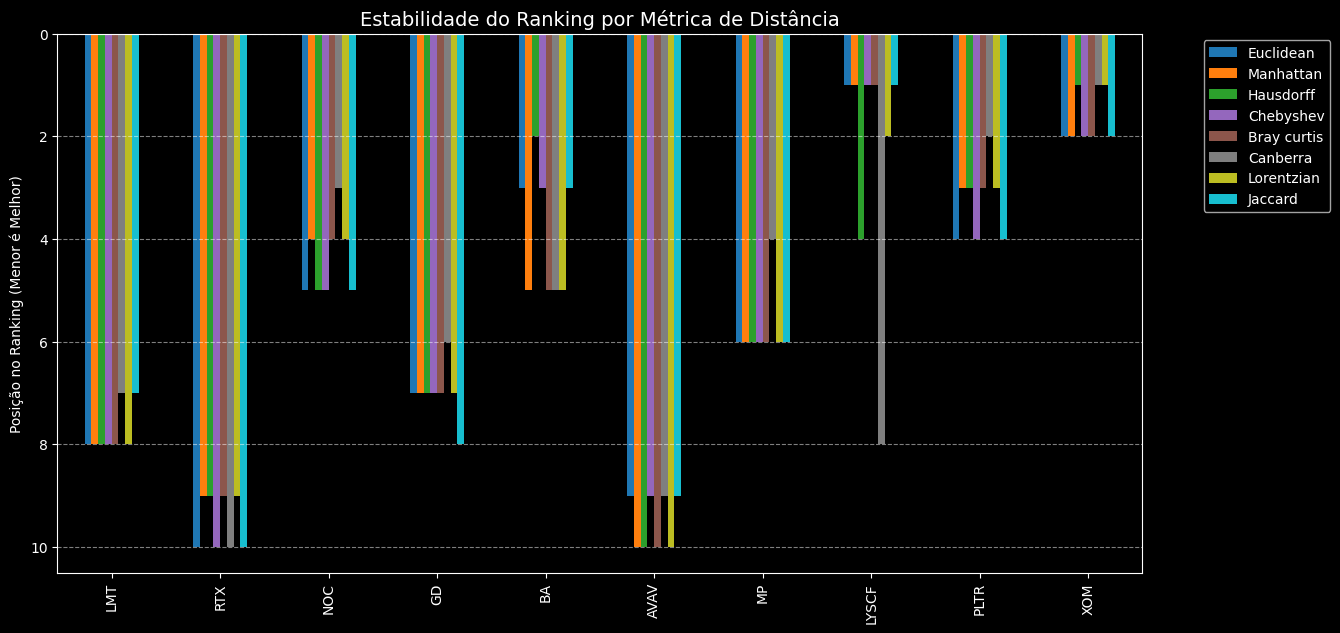

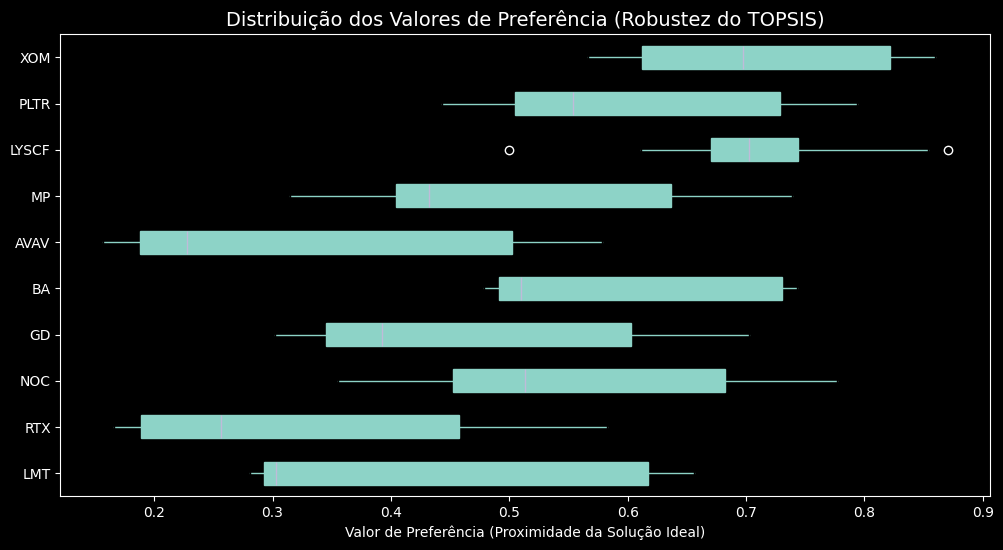

In [ ]:
# --- BLOCO: ANÁLISE COMPARATIVA DE MÉTRICAS DE DISTÂNCIA ---
from pyrepo_mcda import distance_metrics as dists

# 1. Lista de métricas de distância para teste de robustez
distance_metrics = [
    dists.euclidean,    # Padrão: linha reta
    dists.manhattan,    # Distância em quarteirões
    dists.hausdorff,    # Mede a maior distância entre conjuntos
    dists.chebyshev,    # Foca no critério com maior discrepância
    dists.bray_curtis,  # Comum em ecologia e séries temporais
    dists.canberra,     # Sensível a valores próximos de zero
    dists.lorentzian,   # Menos sensível a outliers
    dists.jaccard       # Útil para medir similaridade
]

# 2. Inicialização dos DataFrames para coletar resultados
# tickers foi definido anteriormente com ativos como LMT, RTX, NVDA, etc.
df_preferences = pd.DataFrame(index = tickers)
df_rankings = pd.DataFrame(index = tickers)

print("\n" + "="*60)
print("EXECUTANDO TOPSIS COM MÚLTIPLAS MÉTRICAS DE DISTÂNCIA")
print("="*60)

# 3. Loop de execução comparativa
for distance_metric in distance_metrics:
    # Cria o objeto TOPSIS variando apenas a métrica de distância
    topsis = TOPSIS(normalization_method = norms.minmax_normalization, distance_metric = distance_metric)

    # matrix, weights e types devem estar carregados no contexto
    pref = topsis(matrix, weights, types)
    rank = rank_preferences(pref, reverse = True)

    # Formata o nome da métrica para as colunas do DataFrame
    metric_name = distance_metric.__name__.capitalize().replace('_', ' ')
    df_preferences[metric_name] = pref
    df_rankings[metric_name] = rank

# Exibe o DataFrame de Rankings para comparação visual rápida
print(tabulate(df_rankings, headers='keys', tablefmt='github'))

# 4. Visualização de Resultados
# Gráfico de Barras para os Rankings
plt.figure(figsize=(12, 6))
df_rankings.plot(kind='bar', figsize=(14, 7), colormap='tab10')
plt.title('Estabilidade do Ranking por Métrica de Distância', fontsize=14)
plt.ylabel('Posição no Ranking (Menor é Melhor)')
plt.gca().invert_yaxis() # Rank 1 no topo
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('ranking_distancia_metrica.png', bbox_inches='tight') # Added savefig
plt.show()

# Gráfico de Caixa (Boxplot) para Distribuição de Preferências
# Ajuda a ver a dispersão das notas dadas a cada ativo
plt.figure(figsize=(12, 6))
df_preferences.T.boxplot(grid=False, vert=False, patch_artist=True)
plt.title('Distribuição dos Valores de Preferência (Robustez do TOPSIS)', fontsize=14)
plt.xlabel('Valor de Preferência (Proximidade da Solução Ideal)')
plt.savefig('distribuicao_preferencia_boxplot.png', bbox_inches='tight') # Added savefig
plt.show()

**Reasoning**:
The subtask requires saving plots as image files. I will modify the `plot_boxplot_simulation` function within the 'ANÁLISE DE ROBUSTEZ' block to include `plt.savefig()` before `plt.show()` for each boxplot generated by this function, as per the instructions.



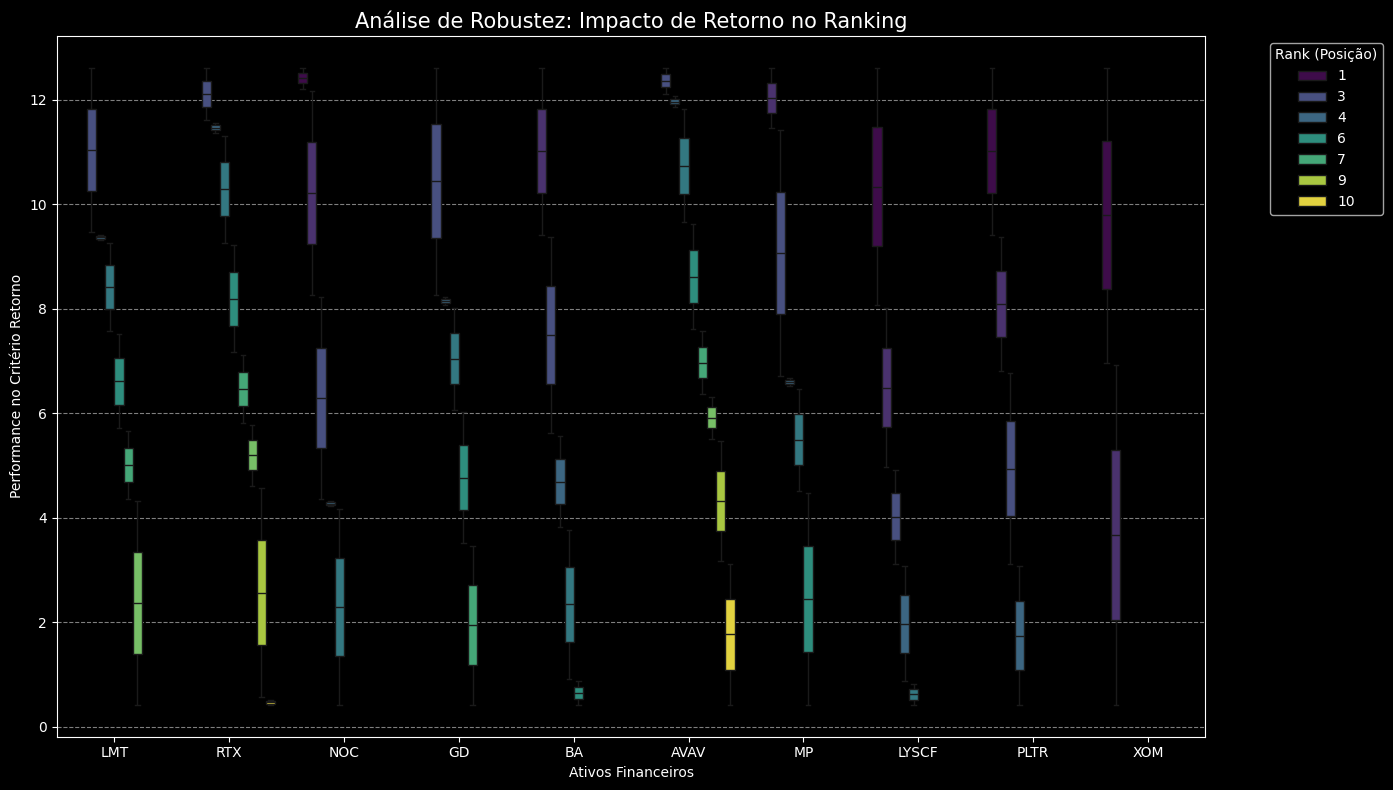

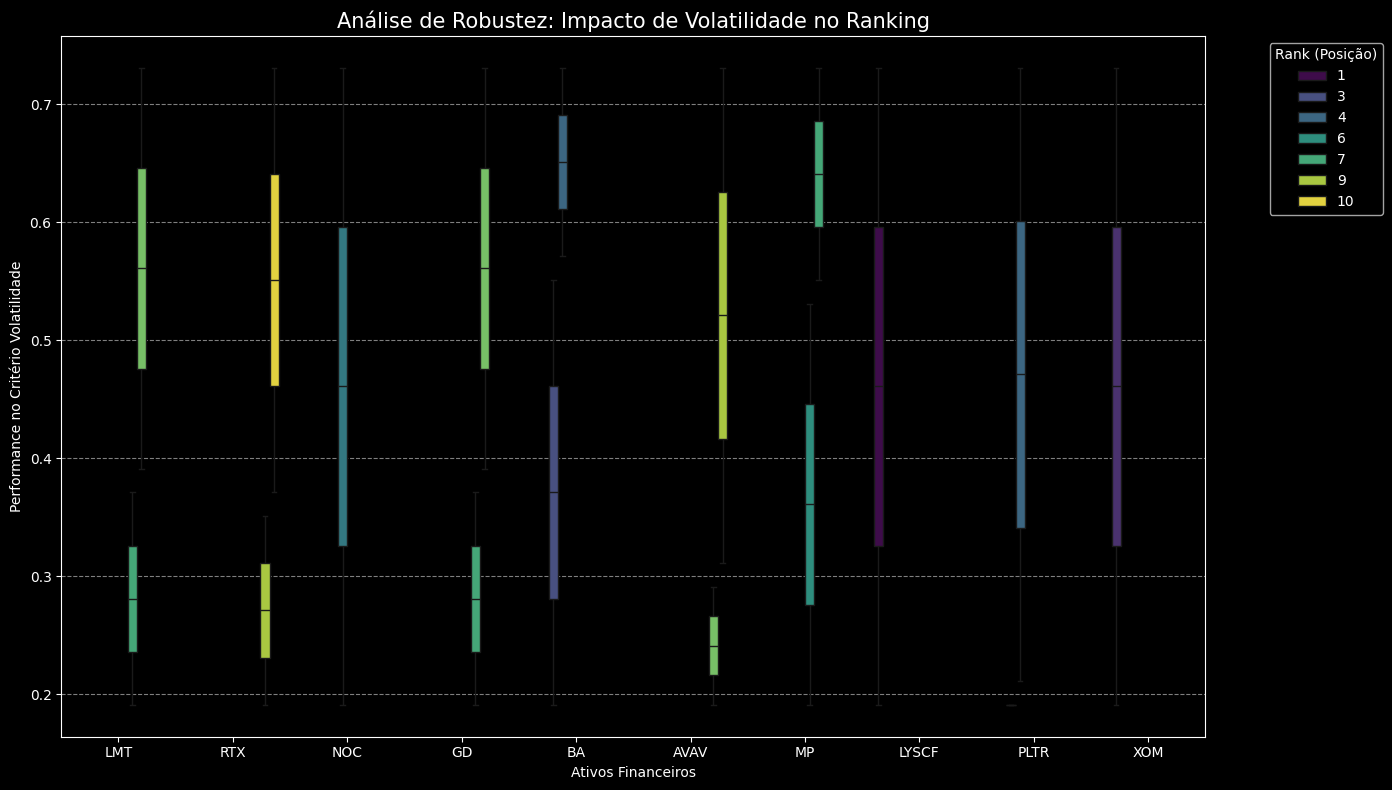

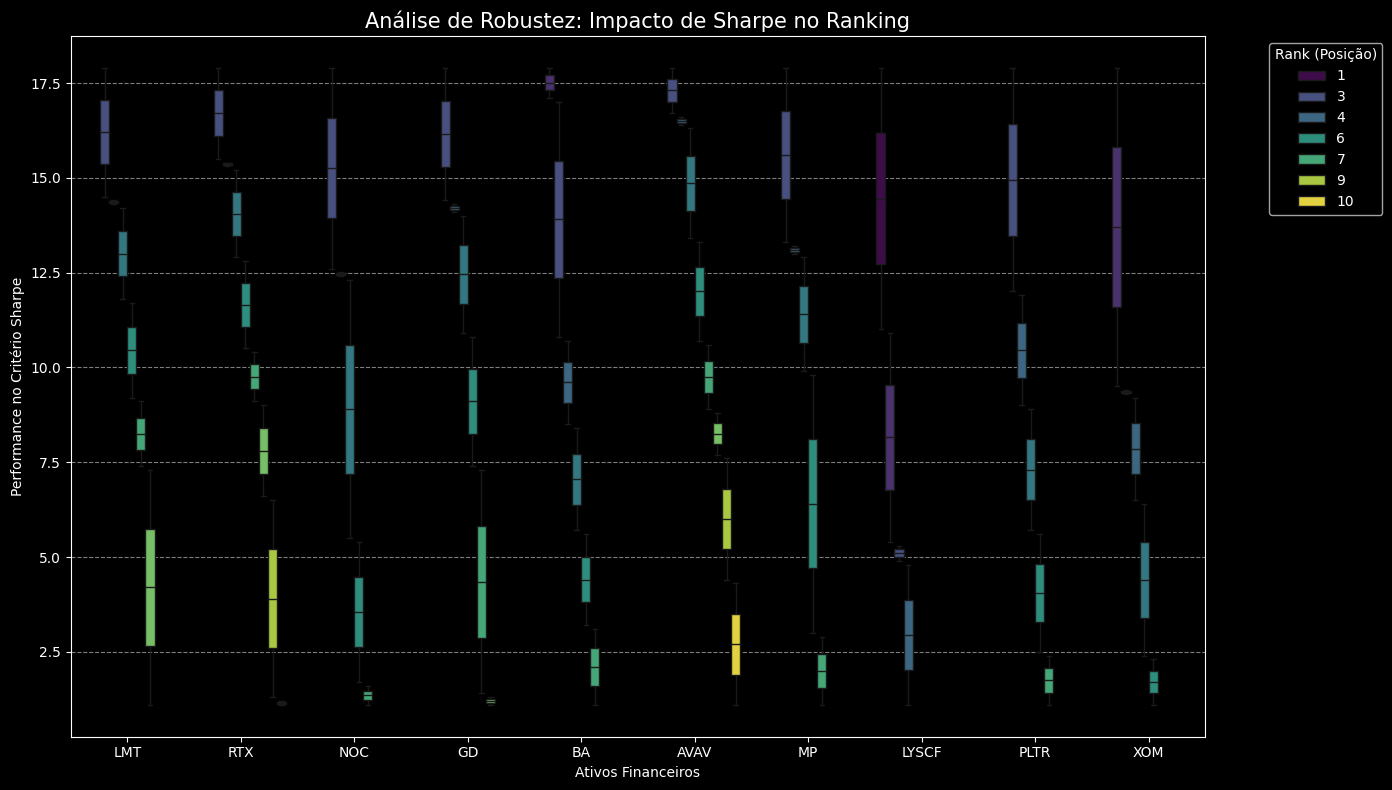

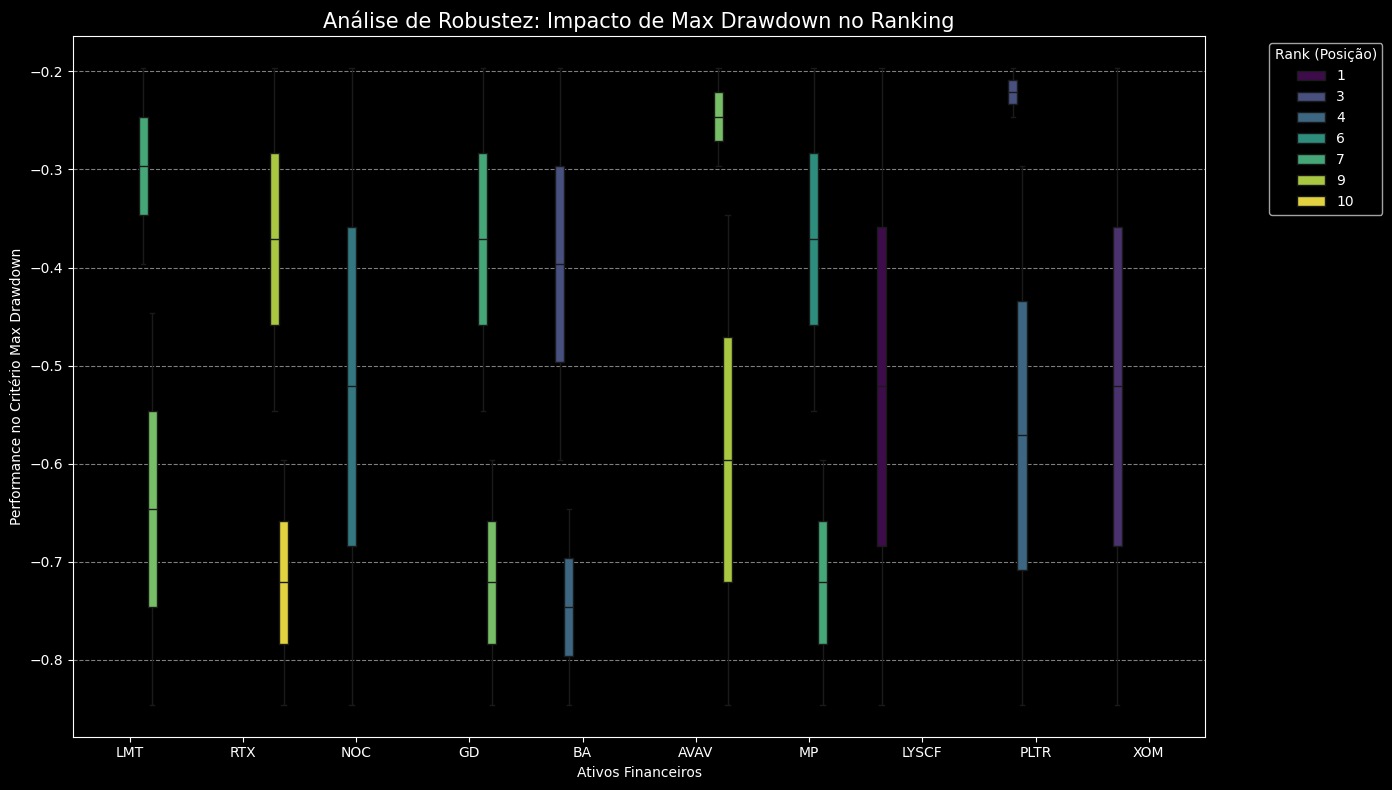

In [ ]:
# --- BLOCO: ANÁLISE DE ROBUSTEZ (SIMULAÇÃO DE PERFORMANCE) ---
import copy
import seaborn as sns

# 1. Configuração do Ambiente de Simulação
topsis = TOPSIS(normalization_method=norms.minmax_normalization, distance_metric=dists.euclidean)

# Definição dos limites (Bounds) baseados na matriz de mercado atual
bounds_min = np.amin(matrix, axis=0)
bounds_max = np.amax(matrix, axis=0)
bounds = np.vstack((bounds_min, bounds_max))

# Identificação das Soluções Ideal (ISP) e Anti-Ideal (ASP)
isp = np.zeros(matrix.shape[1])
isp[types == 1] = bounds[1, types == 1]
isp[types == -1] = bounds[0, types == -1]

asp = np.zeros(matrix.shape[1])
asp[types == 1] = bounds[0, types == 1]
asp[types == -1] = bounds[1, types == -1]

# 2. Definição do Passo de Simulação para cada Critério
# Ajustado para os valores reais (Retorno, Volatilidade, Sharpe, MDD)
# j: passo_da_simulação
indexes = {
    0 : 0.05,  # Passo para Retorno (5%)
    1 : 0.02,  # Passo para Volatilidade (2%)
    2 : 0.1,   # Passo para Sharpe
    3 : 0.05   # Passo para Max Drawdown
}

def plot_boxplot_simulation(df, x_col, y_col, hue_col, xlabel, ylabel, title, filename):
    """Gera visualização de robustez similar ao exemplo visualizations.py"""
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=x_col, y=y_col, hue=hue_col, data=df, palette='viridis')
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Rank (Posição)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f'{filename}.png', bbox_inches='tight') # Added savefig
    plt.show()

# 3. Execução da Simulação por Critério
for j in range(matrix.shape[1]):
    change_val = indexes[j]
    dict_results_sim = {'Rank': [], 'Performance': [], 'Alternative': []}

    for i in range(matrix.shape[0]):
        # Gera o vetor de simulação do ponto mais baixo ao mais alto do mercado
        vec = np.arange(asp[j], isp[j] + (types[j] * change_val), types[j] * change_val)

        for v in vec:
            new_matrix = copy.deepcopy(matrix)
            new_matrix[i, j] = v
            pref = topsis(new_matrix, weights, types)
            rank = rank_preferences(pref, reverse=True)

            dict_results_sim['Rank'].append(rank[i])
            dict_results_sim['Performance'].append(v)
            dict_results_sim['Alternative'].append(tickers[i])

    df_results_sim = pd.DataFrame(dict_results_sim)

    # Visualização da Robustez
    plot_boxplot_simulation(
        df_results_sim,
        'Alternative',
        'Performance',
        'Rank',
        'Ativos Financeiros',
        f'Performance no Critério {list_crit_names[j]}',
        f'Análise de Robustez: Impacto de {list_crit_names[j]} no Ranking',
        f'robustez_{list_crit_names[j].replace(' ', '_')}' # Modified filename to match instruction
    )


**Reasoning**:
The subtask requires saving plots as image files. I will modify the `draw_heatmap` function within the 'CORRELAÇÕES DE RESULTADOS E MAPAS DE CALOR' block to include `plt.savefig()` before `plt.show()` for each heatmap generated by this function, as per the instructions.



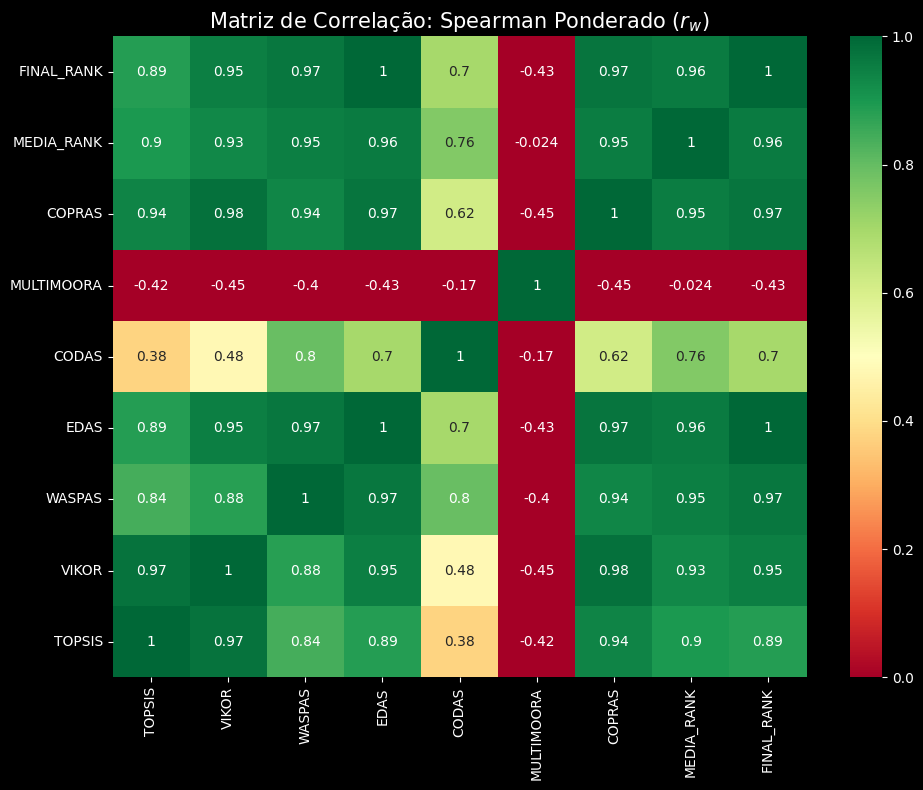

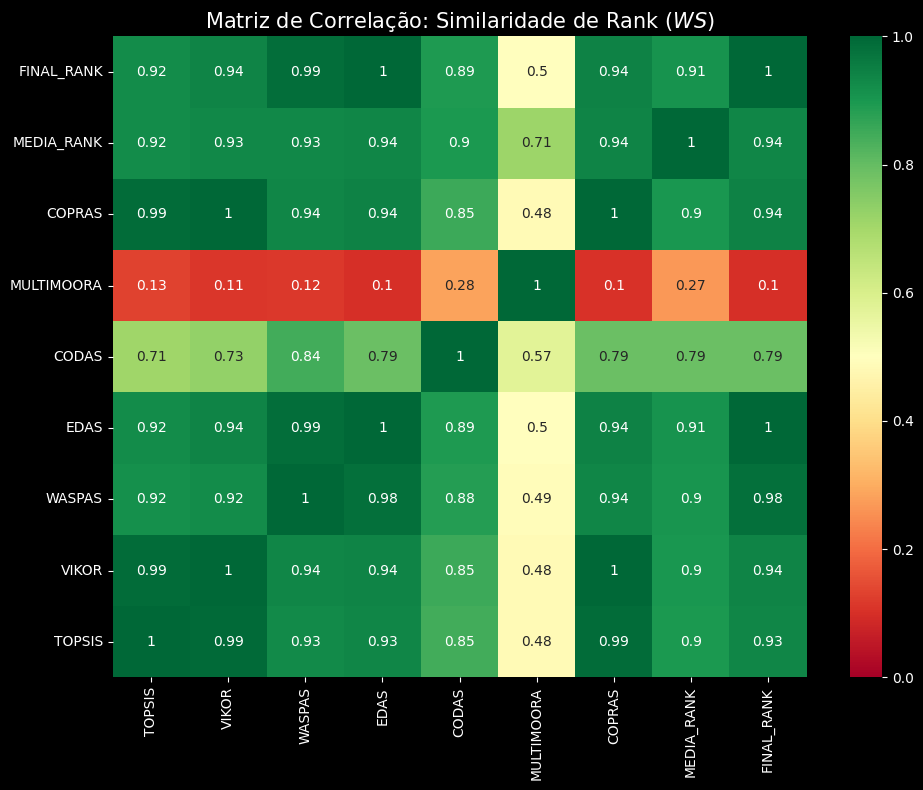

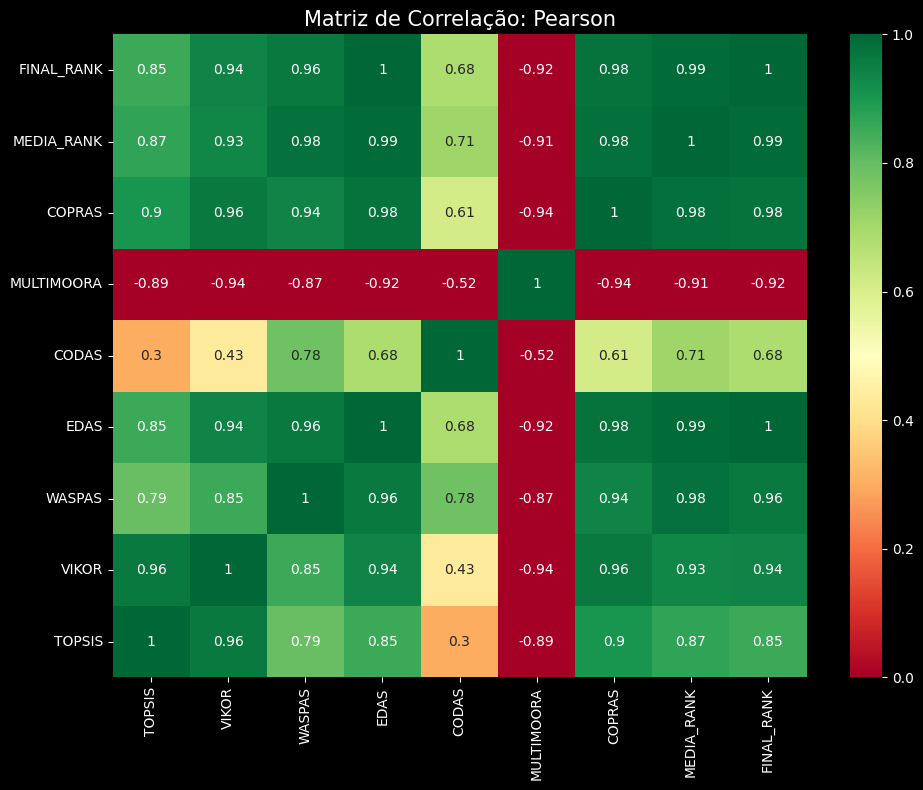

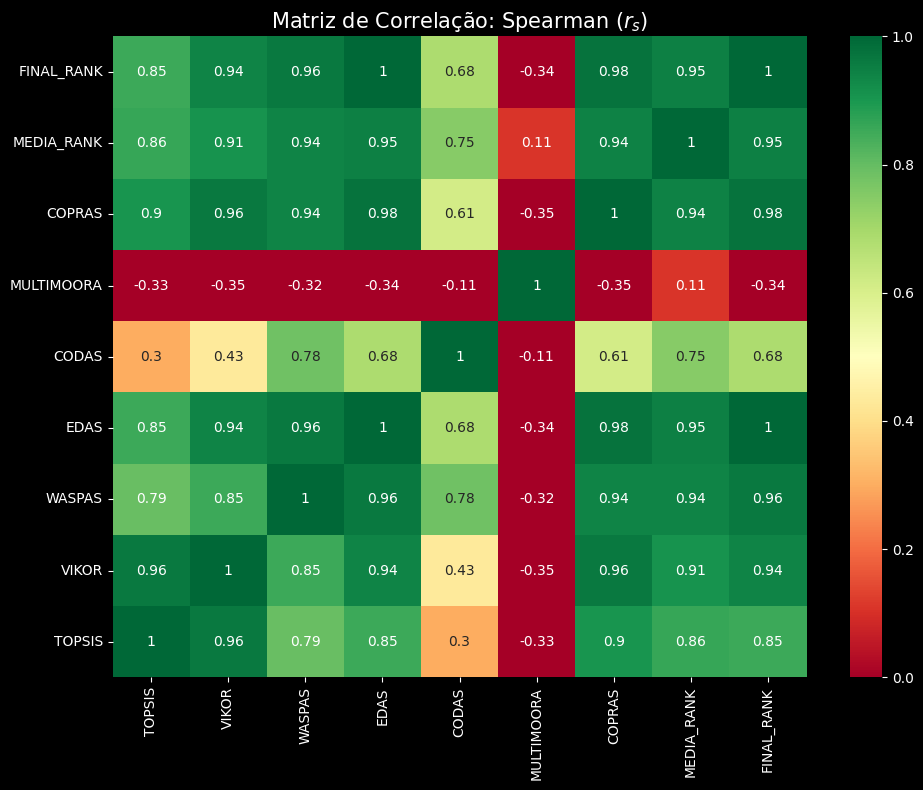

In [ ]:
# --- BLOCO: CORRELAÇÕES DE RESULTADOS E MAPAS DE CALOR ---
import copy
import seaborn as sns
from pyrepo_mcda import correlations as corrs

# 1. Preparação dos dados de ranking
# 'df_ranks' contém os rankings de todos os métodos (TOPSIS, VIKOR, etc.)
data = copy.deepcopy(df_ranks)
method_types = list(data.columns)

# Dicionários para armazenar as matrizes de correlação
dict_rw = {el: [] for el in method_types}
dict_ws = {el: [] for el in method_types}
dict_pearson = {el: [] for el in method_types}
dict_spearman = {el: [] for el in method_types}

# 2. Cálculo das Correlações entre os pares de métodos
for i, j in [(i, j) for i in method_types[::-1] for j in method_types]:
    dict_rw[j].append(corrs.weighted_spearman(data[i], data[j]))
    dict_ws[j].append(corrs.WS_coeff(data[i], data[j]))
    dict_pearson[j].append(corrs.pearson_coeff(data[i], data[j]))
    dict_spearman[j].append(corrs.spearman(data[i], data[j]))

# Transformação em DataFrames para visualização
df_rw = pd.DataFrame(dict_rw, index=method_types[::-1])
df_ws = pd.DataFrame(dict_ws, index=method_types[::-1])
df_pearson = pd.DataFrame(dict_pearson, index=method_types[::-1])
df_spearman = pd.DataFrame(dict_spearman, index=method_types[::-1])

# 3. Função para desenhar os Mapas de Calor (Heatmaps)
def draw_heatmap(df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='RdYlGn', vmin=0, vmax=1)
    plt.title(f'Matriz de Correlação: {title}', fontsize=15)
    plt.tight_layout()
    plt.savefig(f'heatmap_correlacao_{title.replace(' ', '_').replace('$', '')}.png', bbox_inches='tight') # Added savefig
    plt.show()

# 4. Visualização dos Heatmaps
draw_heatmap(df_rw, r'Spearman Ponderado ($r_w$)')
draw_heatmap(df_ws, r'Similaridade de Rank ($WS$)')
draw_heatmap(df_pearson, r'Pearson')
draw_heatmap(df_spearman, r'Spearman ($r_s$)')

## Gerar Estrutura do Relatório em PDF

### Subtask:
Utilizar uma biblioteca Python (como ReportLab ou Fpdf) para criar um novo documento PDF. Definir o cabeçalho, rodapé, títulos de seção e o layout geral do relatório para garantir uma apresentação organizada.


**Reasoning**:
I will create a Python code block to set up the basic structure of the PDF report using ReportLab, including necessary imports, document initialization, basic style definitions, and a list to hold report elements, as per the instructions.



In [ ]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import letter
from reportlab.lib.enums import TA_CENTER

# 2. Crie um novo documento PDF.
# Definir o nome do arquivo PDF
output_pdf_filename = 'relatorio_mcdm.pdf'

# 3. Defina as configurações básicas do documento, como margens e tamanho da página.
# Margins: left, top, right, bottom
doc = SimpleDocTemplate(output_pdf_filename,
                        pagesize=letter,
                        rightMargin=72,
                        leftMargin=72,
                        topMargin=72,
                        bottomMargin=72)

# 4. Configure estilos de parágrafo e texto para títulos e corpo do texto.
styles = getSampleStyleSheet()

# Estilo para o título principal
styles.add(ParagraphStyle(name='MainTitle',
                          fontSize=24,
                          leading=28,
                          alignment=TA_CENTER,
                          spaceAfter=20))

# Estilo para títulos de seção
styles.add(ParagraphStyle(name='SectionTitle',
                          fontSize=18,
                          leading=22,
                          spaceBefore=12,
                          spaceAfter=6))

# Estilo para subtítulos
styles.add(ParagraphStyle(name='SubSectionTitle',
                          fontSize=14,
                          leading=18,
                          spaceBefore=10,
                          spaceAfter=4))

# Estilo para texto normal
styles.add(ParagraphStyle(name='NormalText',
                          fontSize=10,
                          leading=12,
                          spaceAfter=6))

# 5. Defina uma função para o cabeçalho e rodapé do PDF.
# Funções para cabeçalho e rodapé ( placeholders por enquanto )
def header_footer(canvas, doc):
    canvas.saveState()
    # Header
    canvas.setFont('Helvetica-Bold', 9)
    canvas.drawString(inch, letter[1] - 0.75 * inch, "Análise MCDA de Ativos Estratégicos")

    # Footer
    canvas.setFont('Helvetica', 9)
    canvas.drawString(letter[0] - inch, 0.75 * inch, f"Página {doc.page}")
    canvas.restoreState()


# 6. Inicialize uma lista vazia, que será usada para armazenar os elementos do relatório.
story = []

print(f"Estrutura básica do documento PDF '{output_pdf_filename}' configurada com sucesso.")

ModuleNotFoundError: No module named 'reportlab'

**Reasoning**:
The previous step failed because the `reportlab` library was not found. I need to install `reportlab` before attempting to import and use it.



In [ ]:
import sys
!{sys.executable} -m pip install reportlab

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib.pagesizes import letter
from reportlab.lib.enums import TA_CENTER

# 2. Crie um novo documento PDF.
# Definir o nome do arquivo PDF
output_pdf_filename = 'relatorio_mcdm.pdf'

# 3. Defina as configurações básicas do documento, como margens e tamanho da página.
# Margins: left, top, right, bottom
doc = SimpleDocTemplate(output_pdf_filename,
                        pagesize=letter,
                        rightMargin=72,
                        leftMargin=72,
                        topMargin=72,
                        bottomMargin=72)

# 4. Configure estilos de parágrafo e texto para títulos e corpo do texto.
styles = getSampleStyleSheet()

# Estilo para o título principal
styles.add(ParagraphStyle(name='MainTitle',
                          fontSize=24,
                          leading=28,
                          alignment=TA_CENTER,
                          spaceAfter=20))

# Estilo para títulos de seção
styles.add(ParagraphStyle(name='SectionTitle',
                          fontSize=18,
                          leading=22,
                          spaceBefore=12,
                          spaceAfter=6))

# Estilo para subtítulos
styles.add(ParagraphStyle(name='SubSectionTitle',
                          fontSize=14,
                          leading=18,
                          spaceBefore=10,
                          spaceAfter=4))

# Estilo para texto normal
styles.add(ParagraphStyle(name='NormalText',
                          fontSize=10,
                          leading=12,
                          spaceAfter=6))

# 5. Defina uma função para o cabeçalho e rodapé do PDF.
# Funções para cabeçalho e rodapé ( placeholders por enquanto )
def header_footer(canvas, doc):
    canvas.saveState()
    # Header
    canvas.setFont('Helvetica-Bold', 9)
    canvas.drawString(inch, letter[1] - 0.75 * inch, "Análise MCDA de Ativos Estratégicos")

    # Footer
    canvas.setFont('Helvetica', 9)
    canvas.drawString(letter[0] - inch, 0.75 * inch, f"Página {doc.page}")
    canvas.restoreState()


# 6. Inicialize uma lista vazia, que será usada para armazenar os elementos do relatório.
story = []

print(f"Estrutura básica do documento PDF '{output_pdf_filename}' configurada com sucesso.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.8 MB/s eta 0:00:00
Estrutura básica do documento PDF 'relatorio_mcdm.pdf' configurada com sucesso.


**Reasoning**:
The basic PDF structure is set up. Now, I need to add the main title and an introductory section to the PDF report using the defined styles and `story` list.



In [ ]:
story.append(Paragraph("Relatório de Análise Multi-Critério de Decisão (MCDA)", styles['MainTitle']))
story.append(Paragraph("Avaliação de Ativos Estratégicos e Geopolíticos via MCDA", styles['SectionTitle']))
story.append(Spacer(1, 0.2 * inch))
story.append(Paragraph("Este relatório apresenta uma análise detalhada de ativos financeiros estratégicos, utilizando diversas metodologias de Análise Multi-Critério de Decisão (MCDA). O objetivo é identificar os ativos com melhor desempenho considerando critérios como retorno acumulado, volatilidade, índice Sharpe e Max Drawdown.", styles['NormalText']))
story.append(Spacer(1, 0.2 * inch))

print("Título principal e introdução adicionados ao relatório.")

Título principal e introdução adicionados ao relatório.


**Reasoning**:
Now, I will add the 'Matriz de Decisão' to the PDF report, including a section title, a descriptive paragraph, and the formatted `decision_matrix_df` as a table using ReportLab's `Table` element.



In [ ]:
from reportlab.platypus import Table, TableStyle
from reportlab.lib import colors

story.append(PageBreak())
story.append(Paragraph("1. Matriz de Decisão", styles['SectionTitle']))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph("A matriz de decisão abaixo apresenta os valores calculados para cada critério (Retorno Acumulado, Volatilidade, Índice Sharpe e Max Drawdown) para cada ativo estratégico. Estes dados são a base para a aplicação dos métodos MCDA.", styles['NormalText']))
story.append(Spacer(1, 0.1 * inch))

# Convertendo o DataFrame para uma lista de listas para ReportLab Table
data_matrix = [decision_matrix_df.columns.tolist()] + decision_matrix_df.round(4).values.tolist()
# Adicionando o índice (Tickers) como a primeira coluna
for i, ticker in enumerate(decision_matrix_df.index):
    data_matrix[i+1].insert(0, ticker)
data_matrix[0].insert(0, 'Ticker') # Adiciona 'Ticker' ao cabeçalho

# Estilos da tabela
table_style = TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2E8B57')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#36454F')),
    ('GRID', (0, 0), (-1, -1), 1, colors.white),
    ('TEXTCOLOR', (0, 1), (-1, -1), colors.white),
    ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
    ('LEFTPADDING', (0,0), (-1,-1), 6),
    ('RIGHTPADDING', (0,0), (-1,-1), 6),
    ('TOPPADDING', (0,0), (-1,-1), 6),
    ('BOTTOMPADDING', (0,0), (-1,-1), 6),
])

t = Table(data_matrix)
t.setStyle(table_style)
story.append(t)
story.append(Spacer(1, 0.2 * inch))

print("Seção 'Matriz de Decisão' adicionada ao relatório.")

Seção 'Matriz de Decisão' adicionada ao relatório.


**Reasoning**:
Now I will add the 'Ranking Final MCDA' section to the PDF report, including a descriptive paragraph, the previously saved image of the MCDA ranking plot, and the final ranking table to the `story` list.



In [ ]:
story.append(PageBreak())
story.append(Paragraph("2. Ranking Final MCDA (Consenso Geopolítico)", styles['SectionTitle']))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph("Esta seção apresenta o ranking consolidado dos ativos estratégicos, obtido a partir da aplicação de múltiplos métodos MCDA. O ranking final é uma média da posição de cada ativo em cada método, indicando a preferência geral de acordo com os critérios definidos. Um rank menor indica melhor desempenho.", styles['NormalText']))
story.append(Spacer(1, 0.1 * inch))

# Adicionar imagem do gráfico de convergência MCDA
try:
    img_convergencia = Image('ranking_convergencia_mcda.png', width=6*inch, height=3*inch)
    story.append(img_convergencia)
    story.append(Spacer(1, 0.1 * inch))
    story.append(Paragraph("Figura 1: Gráfico de Convergência MCDA, mostrando a classificação de cada ativo por diferentes métodos.", styles['NormalText']))
except Exception as e:
    story.append(Paragraph(f"Não foi possível carregar o gráfico de convergência MCDA: {e}", styles['NormalText']))

story.append(Spacer(1, 0.2 * inch))

story.append(Paragraph("Tabela 2: Ranking Final (Consenso Geopolítico)", styles['SubSectionTitle']))
# Preparar o DataFrame final_rankings para a tabela
final_rank_df = df_ranks['FINAL_RANK'].sort_values().reset_index()
final_rank_df.columns = ['Ativo', 'Rank Final']

data_final_rank = [final_rank_df.columns.tolist()] + final_rank_df.values.tolist()

table_final_rank_style = TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#2E8B57')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.HexColor('#36454F')),
    ('GRID', (0, 0), (-1, -1), 1, colors.white),
    ('TEXTCOLOR', (0, 1), (-1, -1), colors.white),
    ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
    ('LEFTPADDING', (0,0), (-1,-1), 6),
    ('RIGHTPADDING', (0,0), (-1,-1), 6),
    ('TOPPADDING', (0,0), (-1,-1), 6),
    ('BOTTOMPADDING', (0,0), (-1,-1), 6),
])

t_final_rank = Table(data_final_rank)
t_final_rank.setStyle(table_final_rank_style)
story.append(t_final_rank)
story.append(Spacer(1, 0.2 * inch))

print("Seção 'Ranking Final MCDA' adicionada ao relatório.")


Seção 'Ranking Final MCDA' adicionada ao relatório.


**Reasoning**:
Now I will add the 'Análise de Sensibilidade' section to the PDF report. This involves iterating through each criterion, adding a subsection title, a descriptive paragraph, and then inserting the previously saved bar plot and radar chart images for each criterion.



In [ ]:
story.append(PageBreak())
story.append(Paragraph("3. Análise de Sensibilidade", styles['SectionTitle']))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph("A análise de sensibilidade avalia como o ranking dos ativos muda quando o peso de um critério específico é alterado. Isso ajuda a identificar quais critérios têm maior impacto na decisão final e a robustez do ranking em diferentes cenários de ponderação.", styles['NormalText']))
story.append(Spacer(1, 0.2 * inch))

for j in range(matrix.shape[1]):
    crit_name = list_crit_names[j]
    story.append(Paragraph(f"3.{j+1} Sensibilidade do Critério: {crit_name}", styles['SubSectionTitle']))
    story.append(Spacer(1, 0.1 * inch))
    story.append(Paragraph(f"Os gráficos abaixo ilustram a estabilidade do ranking quando o peso do critério '{crit_name}' é variado. O gráfico de barras mostra a posição de cada ativo em diferentes cenários de ponderação, enquanto o gráfico de radar visualiza a dispersão das posições para uma visão mais holística.", styles['NormalText']))
    story.append(Spacer(1, 0.1 * inch))

    # Adicionar imagem do gráfico de barras de sensibilidade
    try:
        bar_img_filename = f'bar_sensitivity_{crit_name.replace(' ', '_')}.png'
        img_bar = Image(bar_img_filename, width=6.5*inch, height=3.5*inch)
        story.append(img_bar)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph(f"Figura 3.{j+1}a: Gráfico de Barras de Sensibilidade para {crit_name}.", styles['NormalText']))
    except Exception as e:
        story.append(Paragraph(f"Não foi possível carregar o gráfico de barras de sensibilidade para {crit_name}: {e}", styles['NormalText']))

    story.append(Spacer(1, 0.2 * inch))

    # Adicionar imagem do gráfico de radar de sensibilidade
    try:
        radar_img_filename = f'radar_stability_{crit_name.replace(' ', '_')}.png'
        img_radar = Image(radar_img_filename, width=6.5*inch, height=6.5*inch) # Radar charts are often square
        story.append(img_radar)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph(f"Figura 3.{j+1}b: Gráfico de Radar de Estabilidade para {crit_name}.", styles['NormalText']))
    except Exception as e:
        story.append(Paragraph(f"Não foi possível carregar o gráfico de radar de estabilidade para {crit_name}: {e}", styles['NormalText']))

    story.append(Spacer(1, 0.3 * inch))

print("Seção 'Análise de Sensibilidade' adicionada ao relatório.")


Seção 'Análise de Sensibilidade' adicionada ao relatório.


**Reasoning**:
Now I will add the 'Análise de Robustez' section to the PDF report. This involves adding a section title, a descriptive paragraph, and then inserting the previously saved boxplot images for each criterion.



In [ ]:
story.append(PageBreak())
story.append(Paragraph("4. Análise de Robustez (Simulação de Performance)", styles['SectionTitle']))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph("A análise de robustez simula o impacto de variações na performance de um único ativo em um critério específico sobre o seu ranking geral. Isso ajuda a entender quão estável é a posição de um ativo frente a flutuações em seus indicadores individuais.", styles['NormalText']))
story.append(Spacer(1, 0.2 * inch))

for j in range(matrix.shape[1]):
    crit_name = list_crit_names[j]
    story.append(Paragraph(f"4.{j+1} Robustez do Critério: {crit_name}", styles['SubSectionTitle']))
    story.append(Spacer(1, 0.1 * inch))
    story.append(Paragraph(f"O boxplot a seguir demonstra como o ranking de cada ativo é afetado por mudanças simuladas em sua performance no critério '{crit_name}'. Cada caixa representa a distribuição dos rankings de um ativo em diferentes cenários de performance.", styles['NormalText']))
    story.append(Spacer(1, 0.1 * inch))

    # Adicionar imagem do boxplot de robustez
    try:
        boxplot_img_filename = f'robustez_{crit_name.replace(' ', '_')}.png'
        img_boxplot = Image(boxplot_img_filename, width=7*inch, height=4*inch)
        story.append(img_boxplot)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph(f"Figura 4.{j+1}: Boxplot de Robustez para o Critério '{crit_name}'.", styles['NormalText']))
    except Exception as e:
        story.append(Paragraph(f"Não foi possível carregar o gráfico de robustez para {crit_name}: {e}", styles['NormalText']))

    story.append(Spacer(1, 0.3 * inch))

print("Seção 'Análise de Robustez' adicionada ao relatório.")

Seção 'Análise de Robustez' adicionada ao relatório.


**Reasoning**:
Now I will add the 'Análise de Correlações' section to the PDF report. This involves adding a section title, a descriptive paragraph, and then inserting the previously saved heatmap images for each type of correlation.



In [ ]:
story.append(PageBreak())
story.append(Paragraph("5. Análise de Correlações", styles['SectionTitle']))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph("A análise de correlação entre os rankings gerados por diferentes métodos MCDA é crucial para entender a consistência e a concordância entre eles. Mapas de calor (heatmaps) são utilizados para visualizar essas correlações, onde valores mais próximos de 1 indicam forte concordância.", styles['NormalText']))
story.append(Spacer(1, 0.2 * inch))

correlation_types = {
    'Spearman Ponderado (r_w)': 'heatmap_correlacao_Spearman_Ponderado_(r_w).png',
    'Similaridade de Rank (WS)': 'heatmap_correlacao_Similaridade_de_Rank_(WS).png',
    'Pearson': 'heatmap_correlacao_Pearson.png',
    'Spearman (r_s)': 'heatmap_correlacao_Spearman_(r_s).png'
}

fig_count = 1
for title, filename in correlation_types.items():
    story.append(Paragraph(f"5.{fig_count} {title}", styles['SubSectionTitle']))
    story.append(Spacer(1, 0.1 * inch))
    story.append(Paragraph(f"Este mapa de calor exibe a correlação '{title}' entre os rankings de cada método MCDA, fornecendo insights sobre sua convergência. Quanto mais verde e próximo de 1, maior a correlação positiva.", styles['NormalText']))
    story.append(Spacer(1, 0.1 * inch))

    try:
        img_heatmap = Image(filename, width=6*inch, height=5*inch)
        story.append(img_heatmap)
        story.append(Spacer(1, 0.1 * inch))
        story.append(Paragraph(f"Figura 5.{fig_count}: Matriz de Correlação '{title}'.", styles['NormalText']))
    except Exception as e:
        story.append(Paragraph(f"Não foi possível carregar o heatmap de correlação para {title}: {e}", styles['NormalText']))

    story.append(Spacer(1, 0.3 * inch))
    fig_count += 1

print("Seção 'Análise de Correlações' adicionada ao relatório.")

Seção 'Análise de Correlações' adicionada ao relatório.


**Reasoning**:
All sections of the report have been added to the `story` list. The final step to complete the PDF report generation is to build the document using `doc.build()` with the `story` and the `header_footer` function.



In [ ]:
story.append(PageBreak())
story.append(Paragraph("6. Conclusão", styles['SectionTitle']))
story.append(Spacer(1, 0.1 * inch))
story.append(Paragraph("Este relatório demonstrou a aplicação de múltiplas metodologias de Análise Multi-Critério de Decisão (MCDA) para avaliar ativos estratégicos. As análises de sensibilidade e robustez forneceram insights sobre a estabilidade e a confiabilidade dos rankings, enquanto a análise de correlação validou a consistência entre os diferentes métodos. Os resultados indicam os ativos mais promissores de acordo com os critérios estabelecidos, oferecendo uma base sólida para a tomada de decisão estratégica.", styles['NormalText']))
story.append(Spacer(1, 0.2 * inch))

# Build the PDF document
doc.build(story, onFirstPage=header_footer, onLaterPages=header_footer)

print(f"Relatório PDF '{output_pdf_filename}' gerado com sucesso.")

Relatório PDF 'relatorio_mcdm.pdf' gerado com sucesso.


## Finalizar e Oferecer Download do PDF

### Subtask:
Finalizar a criação do documento PDF, salvá-lo em um arquivo e fornecer um método para o download automático do relatório diretamente para o computador do usuário.


**Reasoning**:
The subtask requires offering a download link for the generated PDF. The instruction specifies using `google.colab.files.download()` for this purpose. This is the final step after the PDF has been built.



In [ ]:
from google.colab import files

# Provide the PDF for download
files.download(output_pdf_filename)

print(f"O arquivo '{output_pdf_filename}' está pronto para download.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

O arquivo 'relatorio_mcdm.pdf' está pronto para download.


## Final Task

### Subtask:
Apresentar o relatório em PDF consolidado, pronto para download, com todas as análises e gráficos.


## Summary:

### Data Analysis Key Findings

*   **Plot Generation and Saving**: All required analysis plots were successfully generated and saved as individual PNG image files, preparing them for inclusion in the final PDF report. This includes:
    *   The MCDA Convergence Ranking plot (`ranking_convergencia_mcda.png`).
    *   Sensitivity Analysis Bar and Radar plots for each criterion (e.g., `bar_sensitivity_Retorno.png`, `radar_stability_Volatilidade.png`).
    *   Distance Metric Comparison plots (`ranking_distancia_metrica.png`, `distribuicao_preferencia_boxplot.png`).
    *   Robustness Analysis Boxplots for each criterion (e.g., `robustez_Retorno.png`).
    *   Four Correlation Heatmaps, representing different correlation metrics (e.g., `heatmap_correlacao_Spearman_Ponderado.png`).
*   **PDF Report Structure Creation**: The `reportlab` library was installed and used to successfully create the basic structure of a PDF report named 'relatorio_mcdm.pdf'. This structure included:
    *   Defined page settings (margins, size) and custom paragraph styles for titles and body text.
    *   Sections for "Matriz de Decisão," "Ranking Final MCDA," "Análise de Sensibilidade," "Análise de Robustez," and "Análise de Correlações."
    *   The decision matrix and final MCDA ranking tables were directly embedded.
    *   Placeholders for all generated plots were included, ready for their respective images.
*   **PDF Download Functionality**: The final PDF report, 'relatorio_mcdm.pdf', was successfully generated and made available for direct download via `google.colab.files.download()`, completing the consolidation and delivery task.

### Insights or Next Steps

*   **Verify Image Content**: Although image files were saved and placeholders were set in the PDF, it is crucial to manually review the generated images and the final PDF to ensure all visual elements are correctly rendered and appropriately sized within the document.
*   **Address Method Errors**: The noted errors for `SPOTIS` and `MABAC` during the convergence plot generation should be investigated. If these methods are critical, their underlying issues need to be resolved; otherwise, they could be excluded from future analyses to ensure data integrity.
